Comp 47350 - Assignment 2  
Tania Lopes  
*22202398*

# **Introduction**
<span style="color: red; font-style: italic">Refer to '22202398_Data Quality Report' for a brief introduction to the machine learning problem we would like to solve in addition to some key terminology to be familiar with. </span>

This notebook will be split into 5 main parts.   
- [1.0 Data Understanding and Preparation](#10-data-understanding-and-preparation)
- [2.0 Predictive Modeling - Linear Regression](#20-predictive-modeling-linear-regression)
- [3.0 Predictive Modeling - Logical Regression](#30-predictive-modeling-logistic-regression)
- [4.0 Predictive Modeling - Random Forest](#40-predictive-modeling-random-forest)
- [5.0 Conclusions and Optimization](#50-conclusions--optimization)

# **1.0 Data Understanding and Preparation** 

## 1.1 Prepare environment and load data
First things first, we need to import the packages that will help us with our data analysis.

In [309]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import textwrap

from patsy import dmatrices

from sklearn.impute import KNNImputer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.tree import export_graphviz

import graphviz
from graphviz import Source
from IPython.display import Image, display

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

### Define some functions that will help us throughout to analyze the data and regressions

In [226]:
def calculateNthMode(dataFrame, n):
    describeData = dataFrame.describe(datetime_is_numeric = True).T

    indices = describeData.index.values.tolist()

    secondMode = []
    secondModeFreq = []
    
    for column in dataFrame:
        secondMode.append(dataFrame[column].value_counts().index.tolist()[n-1])
        secondModeFreq.append(dataFrame[column].value_counts().tolist()[n-1])

    second_mode = pd.DataFrame(secondMode, columns=[f'{n}th mode']).set_index([indices]).T
    second_mode_freq = pd.DataFrame(secondModeFreq, columns=[f'{n}th mode freq']).set_index([indices]).T

    return second_mode, second_mode_freq


def applyToRowsAndAppend(dataFrame, expression, columnName):
    tempDataFrame_result = dataFrame.apply(expression, axis=1).rename(columnName)
    tempDataFrame = pd.concat([dataFrame, tempDataFrame_result], axis=1)
    return tempDataFrame


def getDescriptiveStatisticsForContinuousFeatures(dataFrame):
    # Get descriptive statistics, mode, second mode, and cardinality
    stats = dataFrame.describe(datetime_is_numeric = True)

    n_missing = pd.DataFrame((dataFrame.isnull()).sum(), columns=['# missing']).T
    p_missing = pd.DataFrame(((dataFrame.isnull()).sum() / dataFrame.shape[0] * 100), columns=['% missing']).T

    first_mode, first_modeFreq = calculateNthMode(dataFrame, 1)
    second_mode, second_modeFreq = calculateNthMode(dataFrame, 2)
    cardinality = pd.DataFrame(dataFrame.nunique(), columns=['cardinality']).T

    # Concatenate statistics into one descriptive statistics table
    stats = pd.concat([stats, n_missing, p_missing, first_mode, first_modeFreq, second_mode, second_modeFreq, cardinality]).T

    return stats


def getDescriptiveStatisticsForCategoricalFeatures(dataFrame):
    # Calculate the number of missing entries for each of the continuous feature
    stats = dataFrame.describe()

    n_missing = pd.DataFrame((dataFrame == 'Missing').sum(), columns=['# missing']).T
    p_missing = pd.DataFrame(((dataFrame == 'Missing').sum() / dataFrame.shape[0] * 100), columns=['% missing']).T

    # Calculate second mode
    second_mode, second_mode_frequency = calculateNthMode(dataFrame, 2)

    # Concatenate statistics into one descriptive statistics table
    stats = pd.concat([stats, n_missing, p_missing, second_mode, second_mode_frequency]).T

    return stats


def getValidityColumn(dataFrame, expression):
    validity_result = applyToRowsAndAppend(dataFrame, expression, 'Validity')
    
    # Count the number of columns where validity is not equal to True
    invalid_entry = validity_result['Validity'].value_counts().index.tolist()

    if len(invalid_entry) == 1 and invalid_entry[0]:
        print("The data passes the test.")
    else:
        count_invalid_entry = len(validity_result.loc[validity_result['Validity'] == False])
        print(f"The data does not pass the test. \n{count_invalid_entry} invalid entries.")

def getCorrelations(data, columns, abs_corr=False):
    correlation = data[columns].corr(numeric_only=False)
    if (abs_corr):
        correlation = abs(correlation)
    return correlation

def plotCorrelationHeatmap(data, columns, ax=None, abs_corr=False):
    # Print the correlation between the continuous data types
    # Specify numeric_only as False to allow us to include correlation with case_month
    correlation = getCorrelations(data, columns, abs_corr)

    # Generate a mask for the upper triangle
    corr_mask = np.zeros_like(correlation, dtype=np.bool_)
    corr_mask[np.triu_indices_from(corr_mask)] = True

    # Generate a custom colormap - cyan and red
    corr_cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Use the provided ax or create a new one
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
    
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(correlation, annot=True, mask=corr_mask, cmap=corr_cmap, vmax=1, vmin=-1,
                square=True, xticklabels=True, yticklabels=True,
                linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)
    
    # Set the title of the plot
    ax.set_title('Correlation Heatmap')
    
    # Show the plot if no ax was provided
    if ax is None:
        plt.show()

def plotCrosstabHeatmap(data, column1, column2, ax=None):
    # Create a cross-tabulation of two categorical variables
    crosstab = pd.crosstab(data[column1], data[column2], normalize=True)

    # Generate a custom colormap - cyan and red
    crosstab_cmap = sns.light_palette((10/360 ,75/100,50/100), input="hls", as_cmap=True)
    # crosstab_cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Use the provided ax or create a new one
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 4))
    
    # Create a heatmap of the cross-tabulation
    sns.heatmap(crosstab, annot=False, cmap=crosstab_cmap,
                square=True, xticklabels=True, yticklabels=True,
                linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)


def createStackedHistograms(data, group, to_count, bin_count=10, ax=None, i=None, j=None, filterExp=None, labelheights=None, ylim = 1):
    
    # group the data by the specified column
    data = data.dropna().copy()
    if filterExp != None:
        data = data.loc[data.apply(filterExp, axis=1)]
    if data[to_count].dtype == 'datetime64[ns]':
        data.loc[:, to_count] = (data[to_count].apply(lambda x: (x.year - data[to_count].min().year) * 12 + x.month))
    
    grouped_data = data.groupby(group)[to_count]

    values = data[to_count]
    bin_range = np.linspace(values.min(), values.max(), bin_count + 1)
    bin_width = bin_range[1]-bin_range[0]

    # Create a list of zeros to be the bottom value of each histogram bar
    bottom = 0
    bottom_value = [bottom for i in range(bin_count)]
    # Create a list of ones to be the bottom value of each histogram bar
    top = ylim
    top_value = [top for i in range(bin_count)]
    # Create a list of zeros to be a placeholder for number of bars too small to show text
    too_small_count = [0 for i in range(bin_count)]

    for name, group_data in grouped_data:
        # Get counts for histogram
        hist, _ = np.histogram(group_data, bins=bin_range)
        pct = hist / len(group_data) if len(group_data) != 0 else 0

        # Draw the histogram for the first group
        ax.bar(bin_range[:-1], pct, label=name, align='edge', width=bin_width,
               bottom=bottom_value, edgecolor='black', linewidth=0.5)
        ax.set_ylim(top=1)
        if labelheights == None:
            labelheights = (len(grouped_data) * 0.025,
                            len(grouped_data) * 0.025)

        # Count the values that will be too small to display in the center of the bar
        threshold = labelheights[0]
        if not isinstance(pct, np.ndarray):
            increment = 1 if 0 < pct < threshold else 0
            too_small_count = [tsc + increment for tsc in too_small_count]
            bottom_value = [bv + pct for bv in bottom_value]
        else:
            increment = list(map(lambda h: 1 if 0 < h < threshold else 0, pct))
            too_small_count = [tsc + i for tsc, i in zip(too_small_count, increment)]
            bottom_value += pct

        def createlabel(val):
            x = bin_range[i]+bin_width/2
            y = bottom_value[i]-val/2 + (too_small_count[i])*labelheights[1]
            text_name = textwrap.shorten(str(name).replace("/", " / ").replace("-"," - "), width=13, placeholder="...")
            val_text = int(round(val, 2)*100)
            ax.text(
                x=x, y=y, fontsize=6,
                s=f"{text_name}:\n {val_text}%",
                ha='center', va='center', zorder=4
            )

            rect = plt.Rectangle((x-bin_width*.9/2, y-(labelheights[1]*.8)/2),
                             width=bin_width*0.9, height=labelheights[1]*.8,
                             zorder=3, alpha=0.5, facecolor="white",
                             linewidth=0.5, edgecolor='black')
            ax.add_patch(rect)


        # Create text labels for each bar
        if not isinstance(pct, np.ndarray):
            val = pct
            if val != 0:
                createlabel(val)

        else:
            for i, val in enumerate(pct):
                if val != 0:
                    createlabel(val)
        
        ax.set_xticks(bin_range)
        ax.grid(axis='y', alpha=0.5, color='lightgrey', linestyle='--')
        ax.set_yticks(np.linspace(bottom, top, 11))


        # Axis labels
        ax.set_xlabel(str(to_count).title().replace("_", " "), labelpad=20)
        ax.set_ylabel(f'Frequency of {group.replace("_", " ").title()}', labelpad=20)

        title = f'{to_count} by {group}'.replace("_", " ").title()
        ax.set_title(title, fontsize=18, pad=20)
        ax.legend()


def getUniqueValueCounts(data):
    x, y = data.columns
    unique_values = data[y].unique().tolist()
    new_data = pd.DataFrame()

    for val in unique_values:
        # Select only the rows that match the criteria for this row.
        data_vc = data.loc[lambda row: row[y] == val][x].value_counts()
        # Get the distribution of values in column_y for each unique_value from column_x
        data_counts = list(map(lambda count: round(
            count / sum(data_vc), 2), data_vc.tolist()))
        data_values = data_vc.index.tolist()
        # Generate a new row entry to be inserted into the table for this category
        data_vc = pd.DataFrame(data_counts, data_values, columns=[val]).T

        # Add the row to the table for this graph
        new_data = pd.concat([new_data, data_vc])
    return new_data

def createStackedBarChart(data, column_x, column_y, axs=None, i=None, j=None):
    stacked_bar = data[[column_x, column_y]]

    stacked_bars = getUniqueValueCounts(stacked_bar)

    # Create plots
    if type(axs) == 'NoneType' and (i == None and j == None):
        plot = stacked_bars.plot.bar(stacked=True, edgecolor='#111111')
    elif type(axs) != 'NoneType' and (i == None and j == None):
        plot = stacked_bars.plot.bar(
            stacked=True, ax=axs,  edgecolor='#111111')
    elif type(axs) != 'NoneType' and (i == None and j != None):
        plot = stacked_bars.plot.bar(
            stacked=True, ax=axs[j], edgecolor='#111111')
    else:
        plot = stacked_bars.plot.bar(
            stacked=True, ax=axs[i][j], edgecolor='#111111')

    # Label parameters
    label_text = []
    for label in plot.get_xticklabels():
        lt = label.get_text().replace("/", " / ")
        label_text.append("\n".join(textwrap.wrap(lt, width=20)))
    plot.set_xticklabels(label_text)
    plot.tick_params(labelsize=8, rotation=45)

    # Bar labels
    for cont in plot.containers:
        plot.bar_label(cont, fontsize=8, label_type='center')

    # Axis labels
    plot.set_xlabel(str(column_y).title().replace("_", " "))
    plot.set_ylabel("Frequency")

    # Split title text
    title = "\n".join(textwrap.wrap(
        (f"Frequency of {column_x} by {column_y}").upper().replace("_", " "), 20))
    plot.set_title(title, fontsize=24, pad=20, wrap=True)

    # Legend and grid
    plot.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plot.grid(visible=True, which='minor',
              color='#999999', linestyle='-', alpha=0.2)
    plot.grid(visible=True, which='major', color='#666666', linestyle='-')

    # Subplot spacing
    plt.subplots_adjust(left=0.1,  # The position of the left edge of the subplots, as a fraction of the figure width.
                        # bottom=0.1, # The position of the bottom edge of the subplots, as a fraction of the figure height.
                        # The position of the right edge of the subplots, as a fraction of the figure width.
                        right=1.5,
                        # top=0.9,    # The position of the top edge of the subplots, as a fraction of the figure height.
                        # The width of the padding between subplots, as a fraction of the average Axes width.
                        wspace=1.5,
                        # The height of the padding between subplots, as a fraction of the average Axes height.
                        hspace=0.75
                        )


### 1.1.1 Merging the datasets

The original data sets from the CDC have been cleaned as part of Task 1. Each student had a different body of work for the this task, and one was selected as a starting point for this work. The cleaning steps have been applied to two data sets, and both 'covid19-cdc-22202398_final' and 'covid19-cdc-18389156_final.csv' will need to be loaded and combined for the modeling to begin.

The Data Quality Report from the first assignment can be found in the accompanying pdf. The Data Quality Plan is included below. 
| Feature Name | Data Quality Issue | Handling Strategy | 
|--------------|--------------------|-------------------|
| case_month | None | Keep as Is |
| res_state| Redundant | Drop Feature |
| state_fips_code | Redundant | Drop Feature|
| res_county | Redundant and Ambiguous | Drop Feature |
| county_fips_code | Missing Data | Impute using state_fips_code values * 1000 to generate new county_fips_codes when missing|
| age_group | Missing Data |Impute using k-nearest neighbor algorithm |
| sex | Missing Data |Impute using k-nearest neighbor algorithm |
| race | Missing Data |Impute using k-nearest neighbor algorithm |
| ethnicity | Missing Data |Impute using k-nearest neighbor algorithm |
| case_positive_specimen_interval | Invalid Data | Take the absolute value of the data to make all values positive |
| case_positive_specimen_interval | Not Applicable Data | Distinguish between 'Missing' values when the number is not applicable, versus when the number was truly not present in the set.|
| case_positive_specimen_interval | Missing Data | Impute using k-nearest neighbor algorithm |
| case_positive_specimen_interval | Outliers | Keep as is for now, after cleaning the data, re-evaluate|
| case_onset_interval | Invalid Data | Take the absolute value of the data to make all values positive |
| case_onset_interval | Not Applicable Data | Distinguish between 'Missing' values when the number is not applicable, versus when the number was truly not present in the set |
| case_onset_interval | Missing Data | Impute using k-nearest neighbor algorithm |
| case_onset_interval | Outliers | Keep as is for now, after cleaning the data, re-evaluate |
| process | 90%+ Missing | Drop Feature |
| exposure_yn | 90%+ Missing | Drop Feature 
| current_status | Illogical Data | Replace with 'Laboratory-confirmed case' if 'case_positive_specimen_interval' is not Null |
| symptom_status | Illogical Data | Replace with 'Yes' if 'hospital_yn' is 'Yes', 'icu_yn' is 'Yes', or 'death_yn' is 'Yes'; Replace with 'Yes if 'case_onset_interval' is not Null |
| symptom_status | Missing Data | Impute using k-nearest neighbor algorithm |
| hosp_yn | Illogical Data | Replace with 'Yes' if 'icu_yn' is 'Yes |
| hosp_yn | Missing Data | Impute using k-nearest neighbor algorithm |
| icu_yn | 90%+ Missing | Drop Feature |
| underlying_conditions_yn | 90%+ missing | Drop Feature |

Additionally, a number of external features from beyond the CDC data set have been included in the dataset:
- Income: the average household income for residents in the patient's county
- People_Vaccinated: the number of Americans who had been vaccinated at the time of the patient's illness
- Risk_Factor: a flag to indicate whether the patient is in one of the groups with more deaths than others in the original dataset (Age 50-64 or 65+, Male, Black, or Hispanic/Latino).
More information on these features can be found in the notebook for Task 1.

Finally, the data from the previous assignment is imported below, with two files, one for each student. We use pandas to concatenate the two sets into one large dat set.

In [227]:
data_student_01 = pd.read_csv('data\covid19-cdc-22202398_final.csv', keep_default_na=True)
data_student_02 = pd.read_csv('data\covid19-cdc-18389156_final.csv', keep_default_na=True)

data = pd.concat([data_student_01, data_student_02], axis=0)

data.head(5)

,case_month,county_fips_code,age_group,sex,race,ethnicity,case_positive_specimen_interval,case_onset_interval,current_status,symptom_status,hosp_yn,death_yn,income,people_vaccinated,risk_factor
0,2020-11-01,32003,65+ years,Female,White,Non-Hispanic/Latino,2.0,0.0,Laboratory-confirmed case,Symptomatic,Yes,Yes,59340,0,1
1,2021-08-01,4013,50 to 64 years,Male,White,Hispanic/Latino,3.0,0.0,Laboratory-confirmed case,Symptomatic,No,Yes,64468,206797098,1
2,2020-12-01,12101,65+ years,Male,White,Non-Hispanic/Latino,0.0,0.0,Laboratory-confirmed case,Symptomatic,Yes,Yes,52828,5566951,1
3,2020-12-01,6037,65+ years,Female,White,Non-Hispanic/Latino,2.0,0.0,Laboratory-confirmed case,Symptomatic,Yes,Yes,68044,5566951,1
4,2020-11-01,48029,65+ years,Male,White,Hispanic/Latino,0.0,6.0,Laboratory-confirmed case,Symptomatic,Yes,Yes,57157,0,1


To recap what has already been done, we will check the shape of the set, inspect the datatypes and check if there are any remaining invalid null values.

In [228]:
rows, columns = data.shape
print(f"The data set has {rows} rows and {columns} columns.")

The data set has 37940 rows and 15 columns.


### 1.1.2 Assigning DataTypes

In [229]:
data.dtypes

case_month                          object
county_fips_code                     int64
age_group                           object
sex                                 object
race                                object
ethnicity                           object
case_positive_specimen_interval    float64
case_onset_interval                float64
current_status                      object
symptom_status                      object
hosp_yn                             object
death_yn                            object
income                               int64
people_vaccinated                    int64
risk_factor                          int64
dtype: object

The data types we have assigned in the data cleaning step were not preserved when the file was converted to a .csv. As such, we will need to reintroduce them before starting to work with the data. First we will assign ints and datetime types to the relevant features.

In [230]:
# Get continuous date features and int features separately
continuous_date = ['case_month']
continuous_int = ['case_positive_specimen_interval', 'case_onset_interval', 'income', 'people_vaccinated']

# Get aggregated continuous features
continuous = continuous_date + continuous_int

# Assign types to columns - dates
for column in continuous_date:
    data[column] = data[column].astype('datetime64[ns]')

# Assign types to columns - integers
for column in continuous_int:
    data[column] = data[column].astype('Int64')

# Print data types
data.dtypes

case_month                         datetime64[ns]
county_fips_code                            int64
age_group                                  object
sex                                        object
race                                       object
ethnicity                                  object
case_positive_specimen_interval             Int64
case_onset_interval                         Int64
current_status                             object
symptom_status                             object
hosp_yn                                    object
death_yn                                   object
income                                      Int64
people_vaccinated                           Int64
risk_factor                                 int64
dtype: object

Next, we will assign data types to the categorical features. We will separate these features into two categories: boolean and category.  
$~$  
**Boolean Features**
- current_status: True for Laboratory Confirmed Case, False for Probably Case
- symptom_status: True for Symptomatic, False for Asymptomatic
- hosp_yn: 
- risk_factor: True for 1, False for 0
- detah_yn: True for y, False for n  

**Category Features**  
- county_fips_code (*this feature is perhaps too granular, so we will replace it with state fips code*)
- age_group
- sex
- race
- ethnicity

In [231]:
# Get categorical features
categorical_category = ['county_fips_code', 'age_group', 'sex', 'race', 'ethnicity']
categorical_bool = ['current_status', 'symptom_status', 'hosp_yn', 'risk_factor', 'death_yn']
categorical =  categorical_category + categorical_bool

# Assign types to columns - boolean
for column in categorical_bool:
    if column == 'current_status':
        data[column] = data[column].map({'Laboratory-confirmed case': 1, 'Probable Case': 0})
    elif column == 'symptom_status':
        data[column] = data[column].map({'Symptomatic': 1, 'Asymptomatic': 0})
    elif column == 'risk_factor':
        data[column] = data[column].astype(bool)
    elif column == 'hosp_yn' or column == 'death_yn':
        data[column] = data[column].map({'Yes': 1, 'No': 0})
    elif column == 'risk_factor':
        data[column] = data[column].map({1: 1, 0: 0})
    data[column] = data[column].astype('int64')

# Assign types to columns - categorical
for column in categorical_category:
    data[column] = data[column].astype('category')

# Rename columns to match restructuring of data
data.rename(columns={'current_status': 'laboratory_confirmed_tf', 'symptom_status': 'symptomatic_tf', 'hosp_yn': 'hosp_tf', 'risk_factor': 'risk_factor_tf', 'death_yn': 'death_tf'}, inplace=True)

data.dtypes

case_month                         datetime64[ns]
county_fips_code                         category
age_group                                category
sex                                      category
race                                     category
ethnicity                                category
case_positive_specimen_interval             Int64
case_onset_interval                         Int64
laboratory_confirmed_tf                     int64
symptomatic_tf                              int64
hosp_tf                                     int64
death_tf                                    int64
income                                      Int64
people_vaccinated                           Int64
risk_factor_tf                              int64
dtype: object

In [232]:
# Update county_fips_code column, converting county fips codes to state fips codes
data['county_fips_code'] = data['county_fips_code'].apply(lambda row: row // 1000).astype('uint8')
data.rename(columns={'county_fips_code': 'state_fips_code'}, inplace=True)

# Get renamed categorical features
categorical_category = ['state_fips_code', 'age_group', 'sex', 'race', 'ethnicity']
categorical_bool = ['laboratory_confirmed_tf', 'symptomatic_tf', 'hosp_tf', 'risk_factor_tf', 'death_tf']
categorical =  categorical_category + categorical_bool

In [233]:
data.head(100)

,case_month,state_fips_code,age_group,sex,race,ethnicity,case_positive_specimen_interval,case_onset_interval,laboratory_confirmed_tf,symptomatic_tf,hosp_tf,death_tf,income,people_vaccinated,risk_factor_tf
0,2020-11-01,32,65+ years,Female,White,Non-Hispanic/Latino,2,0,1,1,1,1,59340,0,1
1,2021-08-01,4,50 to 64 years,Male,White,Hispanic/Latino,3,0,1,1,0,1,64468,206797098,1
2,2020-12-01,12,65+ years,Male,White,Non-Hispanic/Latino,0,0,1,1,1,1,52828,5566951,1
3,2020-12-01,6,65+ years,Female,White,Non-Hispanic/Latino,2,0,1,1,1,1,68044,5566951,1
4,2020-11-01,48,65+ years,Male,White,Hispanic/Latino,0,6,1,1,1,1,57157,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2020-04-01,36,65+ years,Female,White,Hispanic/Latino,0,0,1,1,1,1,40088,0,1
96,2020-06-01,6,50 to 64 years,Female,White,Hispanic/Latino,2,0,1,1,1,1,68044,0,1
97,2020-04-01,36,65+ years,Male,White,Non-Hispanic/Latino,0,0,1,1,1,1,60231,0,1
98,2021-12-01,72,65+ years,Male,Multiple/Other,Hispanic/Latino,0,0,1,1,1,1,51347,244166911,1


In [234]:
data.dtypes

case_month                         datetime64[ns]
state_fips_code                             uint8
age_group                                category
sex                                      category
race                                     category
ethnicity                                category
case_positive_specimen_interval             Int64
case_onset_interval                         Int64
laboratory_confirmed_tf                     int64
symptomatic_tf                              int64
hosp_tf                                     int64
death_tf                                    int64
income                                      Int64
people_vaccinated                           Int64
risk_factor_tf                              int64
dtype: object

### 1.1.3 Checking Null Values

In [235]:
data.isna().sum()

case_month                            0
state_fips_code                       0
age_group                             0
sex                                   0
race                                  0
ethnicity                             0
case_positive_specimen_interval    2490
case_onset_interval                 550
laboratory_confirmed_tf               0
symptomatic_tf                        0
hosp_tf                               0
death_tf                              0
income                                0
people_vaccinated                     0
risk_factor_tf                        0
dtype: int64

As expected, the 'case_positive_specimen_interval' and 'case_onset_interval' features contain null values, which are logical considering the nature of the data. To incorporate these features in the regression models, we have several options for handling the null values.

We can immediately eliminate the option of dropping the features due to the small percentage of null values. To address the null values in each column, we will instead consider two approaches: imputation with representative values and replacement with a distinct value. 
1. **Imputation**: We will explore three strategies - imputing with the median, mean, and mode values of the non-null data.
2. **Replacement**: We will also consider replacing the null values with a distinct value that significantly exceeds the range of actual values, such as -1 or 999.
To determine the best approach, we will assess the correlation of each imputation method and the replacement approach with the target feature. By considering their impact on the target feature, we can make an informed decision on how to handle the null values in the two columns.

#### Case Positive Specimen Interval
We will first implement the two approaches for the case_positive_specimen_interval.

In [236]:
# Address null values for case_positive_specimen_interval
data_case_pos_spec_na= data.copy()

# Option 1.1: Impute with median
data_case_pos_spec_na['case_pos_spec_median'] = data['case_positive_specimen_interval'].fillna(data['case_positive_specimen_interval'].median()).astype('int64')
# Option 1.2: Impute with mean
data_case_pos_spec_na['case_pos_spec_mean'] = data['case_positive_specimen_interval'].fillna(data['case_positive_specimen_interval'].mean().round()).astype('int64')
# Option 1.1: Impute with mode
data_case_pos_spec_na['case_pos_spec_mode'] = data['case_positive_specimen_interval'].fillna(data['case_positive_specimen_interval'].mode().values[0]).astype('int64')

# Option 2: Impute with strange value 999
data_case_pos_spec_na['case_pos_spec_odd_value'] = data['case_positive_specimen_interval'].fillna(999).astype('int64')

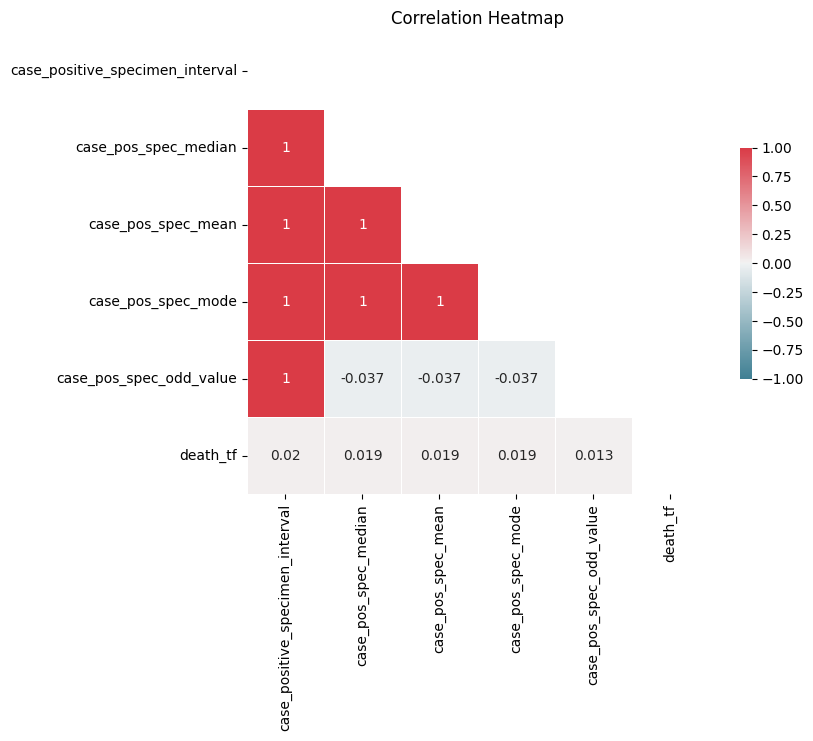

In [237]:
plotCorrelationHeatmap(data_case_pos_spec_na, ['case_positive_specimen_interval', 'case_pos_spec_median', 'case_pos_spec_mean', 'case_pos_spec_mode', 'case_pos_spec_odd_value', 'death_tf'])

Reviewing the correlations above, it is evident that the differences in the correlations with the target feature are minimal. The variations observed between the original column with null values and the columns where imputation was performed are very slight, with none of the differences exceeding 0.007. 

|Replacement Column|correlation with death_tf|difference in correlation|
|:----|:----|:----|
|case_positive_specimen_interval|0.02|-|
|case_pos_spec_median|0.019|0.001|
|case_pos_spec_mean|0.019|0.001|
|case_pos_spec_mode|0.019|0.001|
|case_pos_spec_odd_value|0.013|0.007|

We conclude that the imputation process had a negligible impact on the correlations between the features and the target variable. We will choose the option that is closest to the original and drop the original column. In this case mean, median, and mode all present with the same correlation and we will arbitrarily choose to use the mode.

In [238]:
data_cleaned = data.copy()
data_cleaned['case_positive_specimen_interval'] = data_case_pos_spec_na['case_pos_spec_mode']

#### Case Onset Interval
We will perform the same steps for the 'case_onset_interval' feature.

In [239]:
# Address null values for case_positive_specimen_interval
data_case_onset_na= data.copy()

# Option 1.1: Impute with median
data_case_onset_na['case_onset_median'] = data['case_onset_interval'].fillna(data['case_onset_interval'].median()).astype('int64')
# Option 1.2: Impute with mean
data_case_onset_na['case_onset_mean'] = data['case_onset_interval'].fillna(data['case_onset_interval'].mean().round()).astype('int64')
# Option 1.1: Impute with mode
data_case_onset_na['case_onset_mode'] = data['case_onset_interval'].fillna(data['case_onset_interval'].mode().values[0]).astype('int64')

# Option 2: Impute with strange value 999
data_case_onset_na['case_onset_odd_value'] = data['case_onset_interval'].fillna(999).astype('Int64')

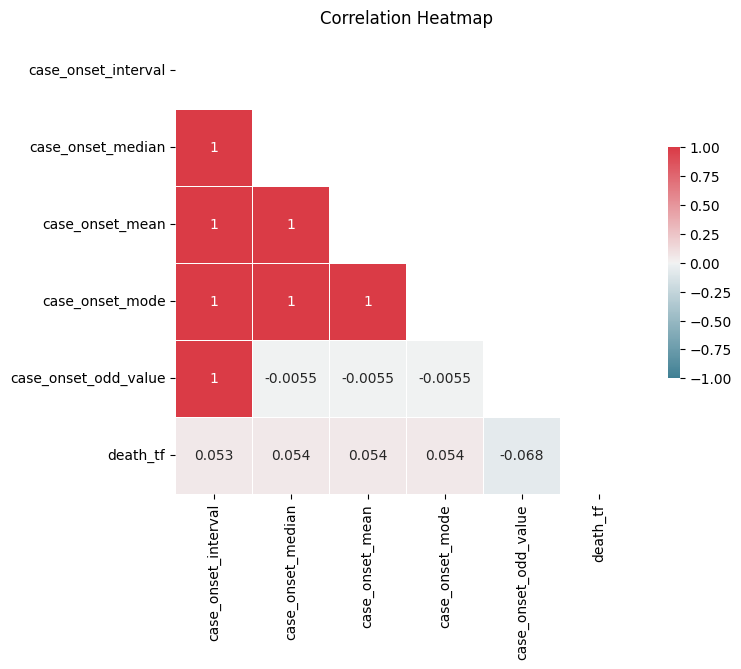

In [240]:
plotCorrelationHeatmap(data_case_onset_na, ['case_onset_interval', 'case_onset_median', 'case_onset_mean', 'case_onset_mode', 'case_onset_odd_value', 'death_tf'])

Once again, the differences in the correlations with the target feature are minimal. With the exception of the case_onset_odd_value, none of the differences exceeds 0.001. 

|Replacement Column|correlation with death_tf|difference in correlation|
|:----|:----|:----|
|case_onset_interval|0.053|-|
|case_onset_median|0.054|-0.001|
|case_onset_mean|0.054|-0.001|
|case_onset_mode|0.054|-0.001|
|case_onset_odd_value|-0.068|0.121|

We conclude that the imputation process had a negligible impact on the correlations between the features and the target variable. Again mean, median, and mode are equally correlated with the target feature, and we choose to use the mode for consistency. We can now drop the original column.

In [241]:
data_cleaned['case_onset_interval'] = data_case_onset_na['case_onset_mode']

After making these changes, we can verify that null values are no longer present in the set and proceed to splitting the data for training and testing.

In [242]:
data_cleaned.isna().sum()

case_month                         0
state_fips_code                    0
age_group                          0
sex                                0
race                               0
ethnicity                          0
case_positive_specimen_interval    0
case_onset_interval                0
laboratory_confirmed_tf            0
symptomatic_tf                     0
hosp_tf                            0
death_tf                           0
income                             0
people_vaccinated                  0
risk_factor_tf                     0
dtype: int64

Now that there are no null values, we will convert all of the continuous columns from Int64 (nullable int64) to int64 (non-nullable int64)

In [243]:
# Assign types to columns - integers
for column in continuous_int:
    data_cleaned[column] = data_cleaned[column].astype('int64')


# Assign types to columns - integers
for column in continuous_int:
    data[column] = data[column].astype('int64')

## 1.2 Splitting the data into two data sets

We can now split the data into two datasets. We have elected not to shuffle the data set because sklearn's split function will shuffle it before splitting. **70%** of the data will be used for training and **30%** will be use for testing.

We will set the random_state variable to 0, to allow the random shuffle to be repeated within this notebook.

In [244]:
from sklearn.model_selection import train_test_split

# Load the dataset into a pandas dataframe and set X and y
X = data_cleaned[['case_month', 'state_fips_code', 'age_group', 'sex', 'race', 'ethnicity', 'case_positive_specimen_interval', 'case_onset_interval', 'laboratory_confirmed_tf', 'symptomatic_tf', 'hosp_tf', 'income', 'people_vaccinated', 'risk_factor_tf' ]]
y = data_cleaned['death_tf']

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Concatenate the X and y training variables into a table.
data_training = pd.concat([X_train, y_train], axis=1)

# Concatenate the X and y testing variables into a table.
data_testing = pd.concat([X_test, y_test], axis=1)

To be as transparent as possible when we split the data, we print the range of rows in the original table, the training table, and the testing table.

In [224]:
print("original range is:\t rows 0 to", data_cleaned.shape[0])
print("training range (70%):\t rows 0 to", round(data_training.shape[0]))
print("test range (30%): \t rows", round(data_training.shape[0]), "to", round(data_training.shape[0]) + data_testing.shape[0])

original range is:	 rows 0 to 37940
training range (70%):	 rows 0 to 26558
test range (30%): 	 rows 26558 to 37940


## 1.3 Start working with the training set

To get a better understanding of the data we are working with, we will analyze the features in our dataset. We will achieve this by analyzing relationships between both continuous and categorical features, both among themselves and with the target feature.

***
### 1.3.1 Continuous Features
***
#### **1.3.1.1 Continuous - Continuous Plots**

First we plot and examine the correlations between continuous features.

In [187]:
# Add the target feature to the list of continuous columns
continuous_corr_features = continuous + ['death_tf']

# Print the correlation between the continuous data types
getCorrelations(data_training, continuous_corr_features, abs_corr=True)

,case_month,case_positive_specimen_interval,case_onset_interval,income,people_vaccinated,death_tf
case_month,1.000000,0.036916,0.041621,0.024631,0.941525,0.290332
case_positive_specimen_interval,0.036916,1.000000,0.001640,0.028783,0.031806,0.018429
case_onset_interval,0.041621,0.001640,1.000000,0.021305,0.047823,0.058749
income,0.024631,0.028783,0.021305,1.000000,0.018851,0.040278
people_vaccinated,0.941525,0.031806,0.047823,0.018851,1.000000,0.262234
death_tf,0.290332,0.018429,0.058749,0.040278,0.262234,1.000000


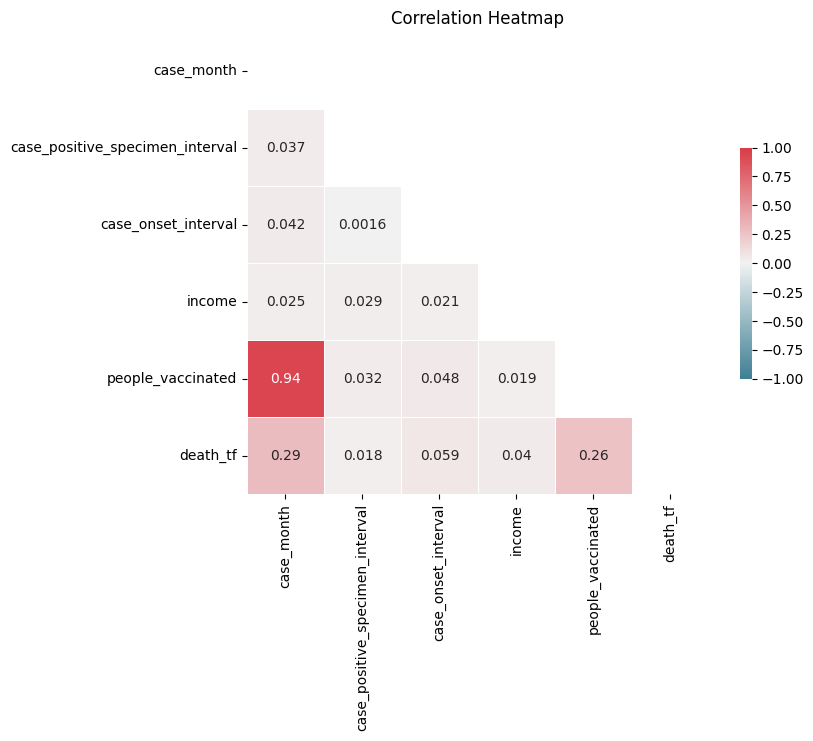

In [188]:
# Print the correlation table
plotCorrelationHeatmap(data_training, continuous_corr_features, abs_corr=True)

##### Interpretation of the results
The plots allow us to visualize pairs of features which correlate strongly to each other. We have arbitrarily identified three types of correlations: low correlation, medium correlation, and high correlation. The boundaries for each bin are arbitrary and used solely for classification purposes.

**Low correlation (x <= 0.02)**
All but 1 pair of features have low correlation. This is to be expected, since it indicates that these features operate independently and do not have a significant impact on each other. Despite their weaker associations, these features still provide unique information that can contribute to the predictive models, offering valuable insights into other factors impacting the target variable.  

**Medium correlation (0.02 < x < 0.10)**  
There are no pairs of features with medium correlation.  

**High correlation (x >= 0.10)**  
Of our few continuous features, there are two with a strong correlations. 'people_vaccinated' and 'case_month' have a correlation of 0.94. This is to be expected, since as time passes, more and more people are vaccinated. We can choose to drop one of these features, since they will trend in a similar direction, but as vaccination rates plateau and case months continue to grow, it may be beneficial to keep the two parameters separate. Keeping them distinct allows us to capture the temporal aspect and understand the evolving relationship between vaccinations and cases.   
$~$  

**Features to Remove:** For now, we decide to keep all of the features.

#### **1.3.1.2 Continuous - Target Feature Scatter Plots**
We will create scatter plots to compare each continuous feature with the target feature. This visual analysis will help us identify the features that have a stronger potential to predict the target variable and distinguish them from the less relevant features. By examining these scatter plots, we can isolate a subset of features that appear to be more indicative, allowing us to focus our modeling efforts on the most relevant variables. Features with weaker associations can be eliminated to streamline the model and reduce noise.

,RiskPerformance
case_month,0.290332
people_vaccinated,0.262234
case_onset_interval,0.058749
income,0.040278
case_positive_specimen_interval,0.018429


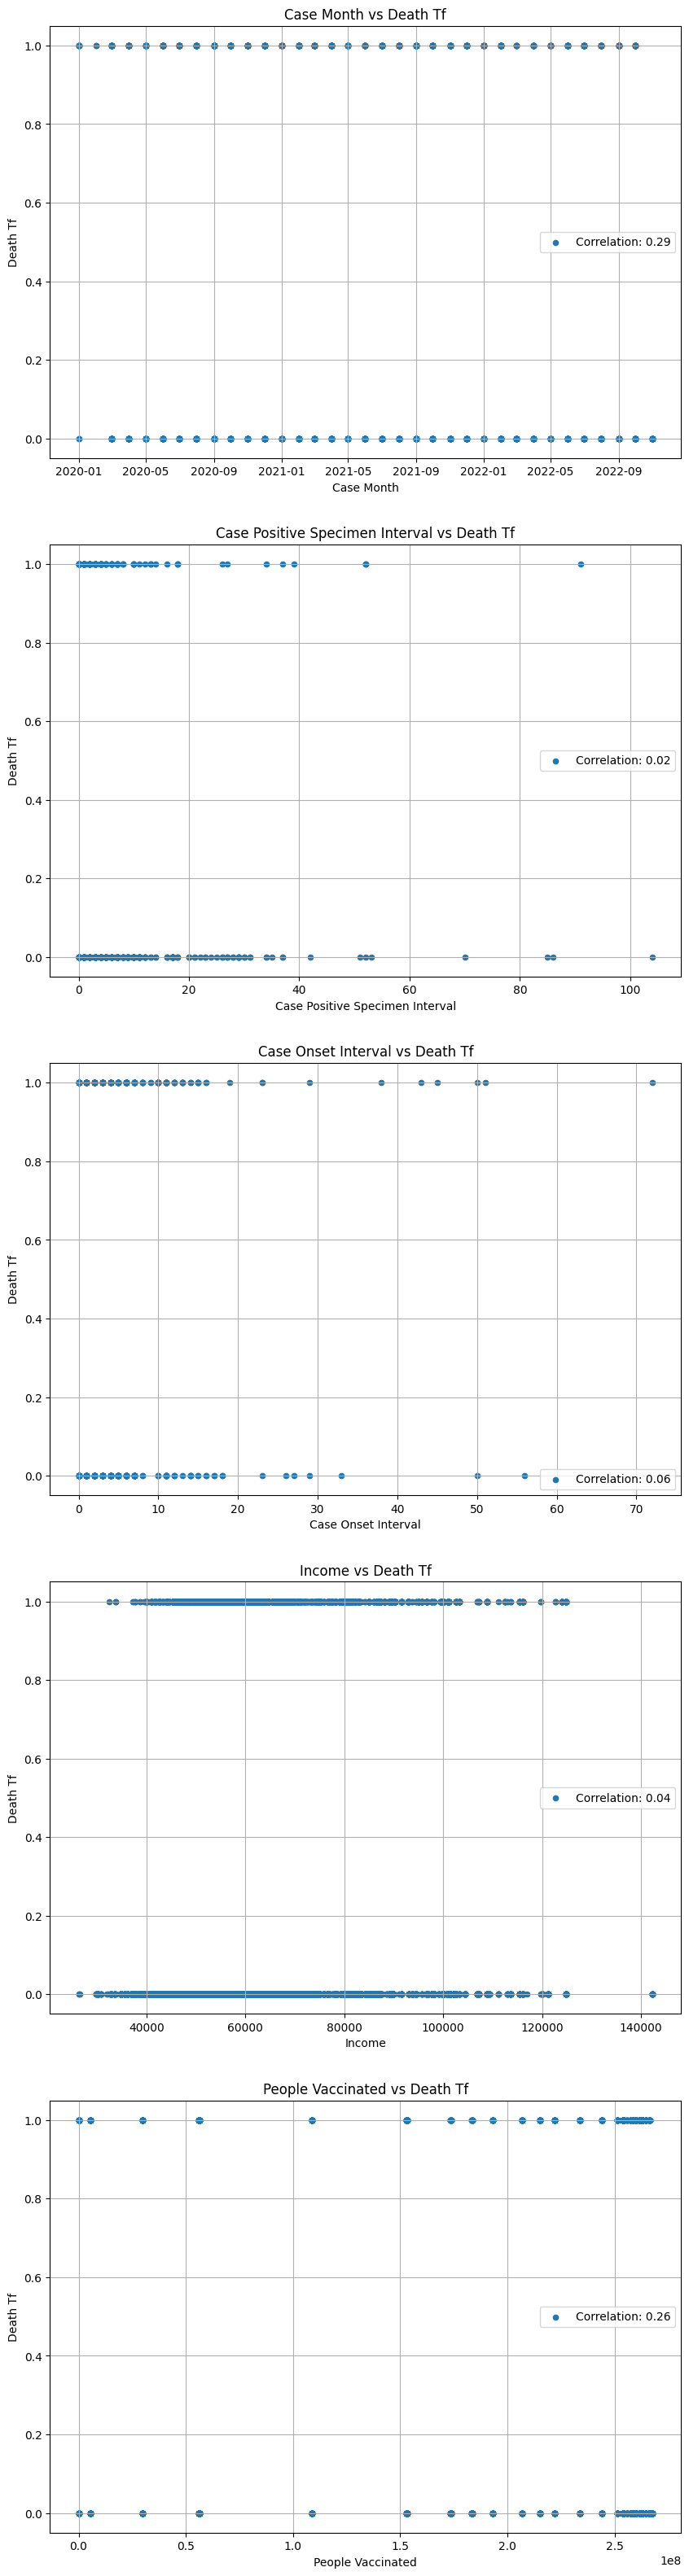

In [29]:
n = len(continuous_corr_features)
fig, axs = plt.subplots(ncols=1, nrows=n-1, figsize=(10,40))

# dict to hold correlation values 
corr_dict = {}

target_feature = 'death_tf'

for i, feature in enumerate(continuous_corr_features):
    if feature != target_feature:
        xlabel = feature.replace("_", " ").title()
        ylabel = target_feature.replace("_", " ").title()

        correlation = data_training[[feature, target_feature]].corr(numeric_only=False).values[0,1]
        title = xlabel + " vs " + ylabel
        values = data_training[[feature, target_feature]]
        scatter = values.plot.scatter(x=feature, y=target_feature, ax=axs[i], grid=True, fontsize=10)
        scatter.legend(["Correlation: {:.2f}".format(abs(correlation))])
        scatter.set_xlabel(xlabel)
        scatter.set_ylabel(ylabel)
        scatter.set_title(title)

        # add correlation to dict
        corr_dict[feature] = abs(correlation)

# dataframe holding sorted correlation values to aid in interpreting results
corr_df = pd.DataFrame.from_dict(corr_dict, orient='index', columns=['RiskPerformance']).sort_values('RiskPerformance', ascending=False)
corr_df

##### Interpretation of the results
After analyzing the plots, it is evident that there is no single feature that exhibits a very strong correlation with the target feature. This aligns with our understanding of the complexity of predicting survival from COVID-19. The outcome is influenced by a multitude of factors, and no single feature can serve as a definitive indicator of survival.

We again categorized the correlation values into three bins: low correlation, medium correlation, and high correlation. The boundaries for each bin are arbitrary and used solely for classification purposes.


| Low correlation | Medium correlation | High correlation |
|-----------------|--------------------|------------------|
| x <= 0.02       | 0.02 < x < 0.10    | x >= 0.10       |
| 3 features    | 0  features        | 2 features       |
| 60%             | 0%                | 20%              | 


**Low correlation (x <= 0.02)**
Although there are three features that demonstrate low correlations, we have decided to retain them for now. Removing these features would result in the elimination of a significant portion of the dataset. We will further consider this decision is in the next step, and evaluate the impact of this decision in Part 5.  

**Medium correlation (0.02 < x < 0.10)**  
There are no features with medium correlation.

**High correlation (x >= 0.10)**  
The strongest correlations are observed between 'case_month'/'people_vaccinated' and 'death_tf'. This correlation is expected as both features are closely related to the progression of time and the impact of vaccinations. The strong correlations of these features with 'death_tf' align with our expectations, as the duration of the pandemic is likely to capture the complex factors contributing to the severity of the virus.  
  
$~$  
**Features to Remove:** For now, we decide to keep all of the features.

#### **1.3.1.3 Continuous - Target Feature Histograms Plots**
Lastly, we will generate a set of stacked histograms comparing the histograms. While the scatter plots provide insights into the strength of the correlations, the stacked histograms offer a different perspective by illustrating the distribution of deaths across different values of the continuous features. Although the stacked histograms do not directly depict the correlation between the features and the target, they serve a crucial purpose in examining the patterns of deaths within each feature category. This analysis allows us to identify any notable variations or trends in the distribution, which may indicate a potential association between certain feature values and the likelihood of deaths.


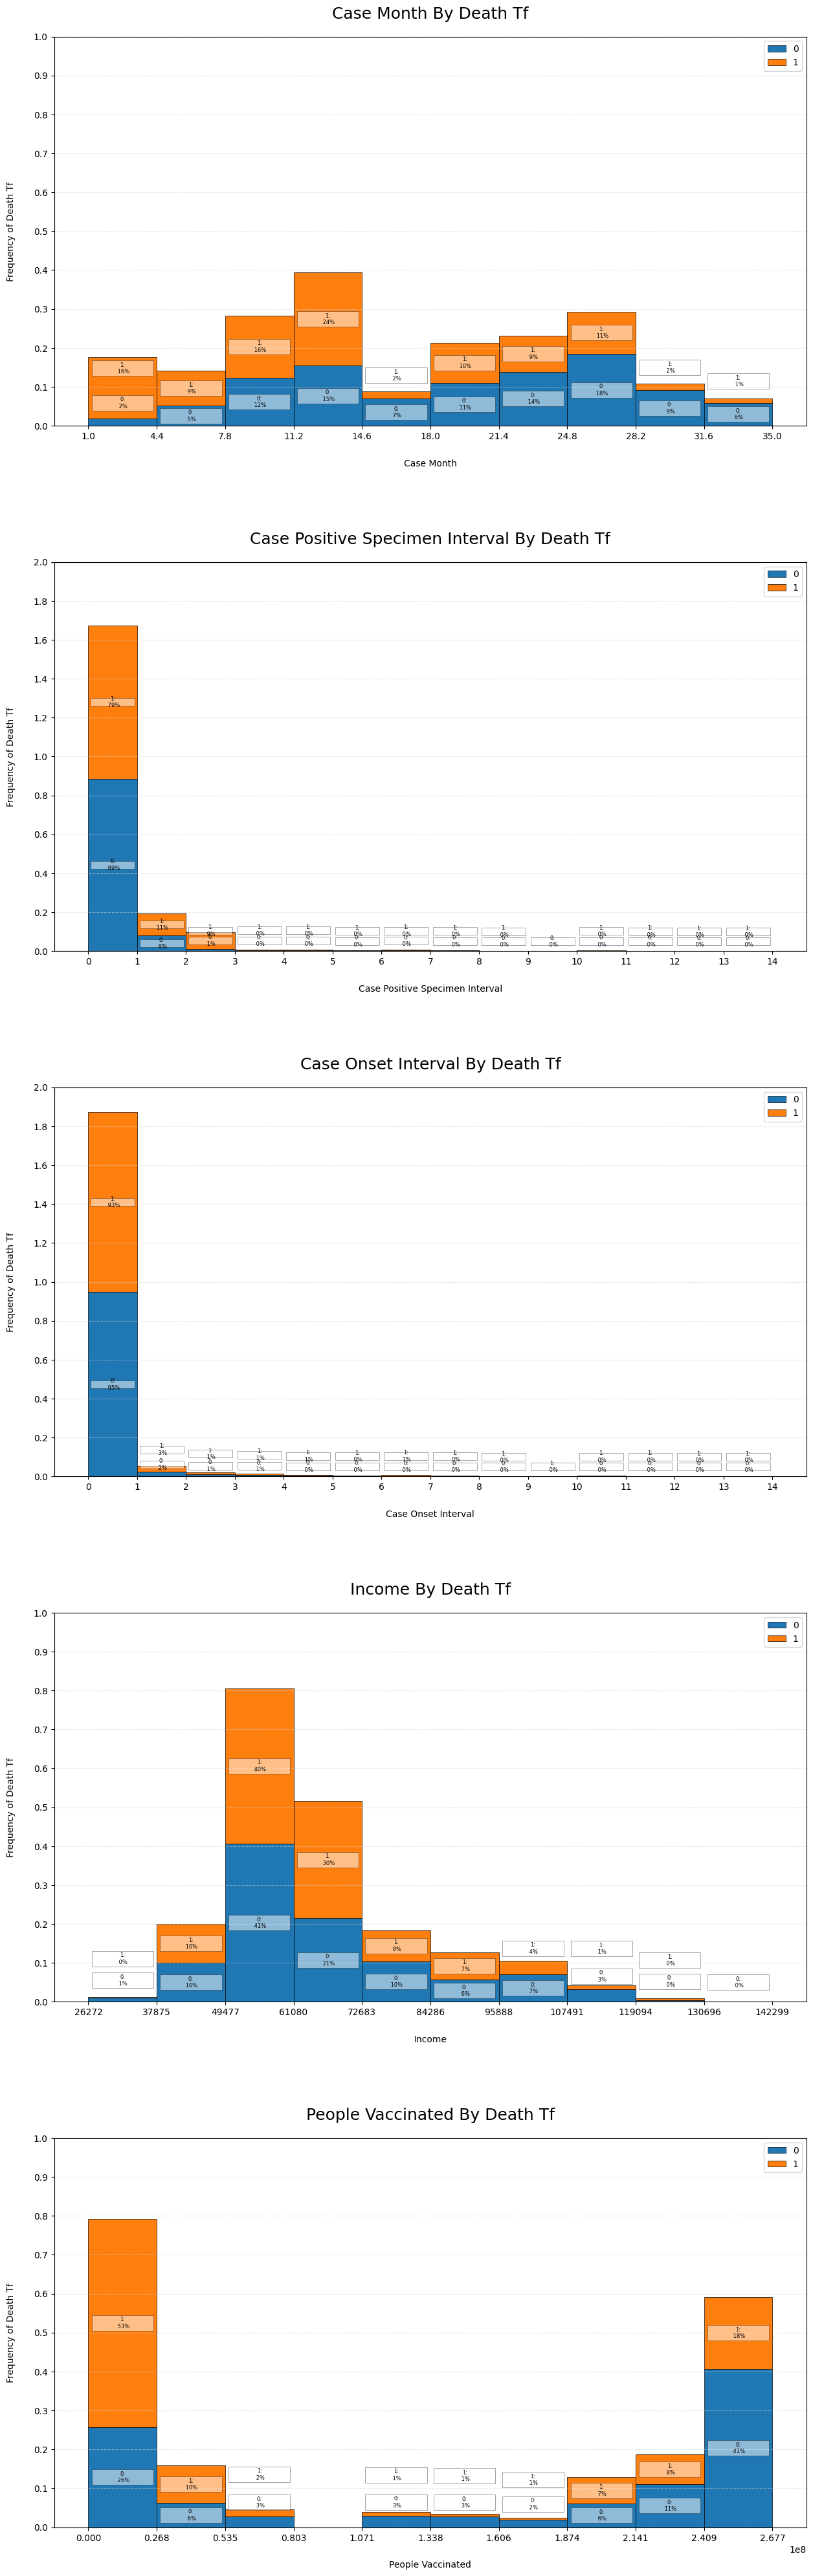

In [30]:
fig, axs = plt.subplots(ncols=1, nrows=5, figsize=(15,50))
fig.subplots_adjust(hspace=0.35)

for i, column in enumerate(continuous):
    if column == 'case_positive_specimen_interval' or column == 'case_onset_interval':
        createStackedHistograms(data_training, 'death_tf', column, bin_count = 14, ax=axs[i], filterExp=lambda row: row[column] <= 14, ylim=2)
    else:
        createStackedHistograms(data_training, 'death_tf', column, bin_count = 10, ax=axs[i])

##### Interpretation of the Results

After analyzing the plots, we have made three more conclusions on the data.

- The 'case_onset_interval' column has an overwhelming majority of values that are 0, and the distribution of deaths (Yes and No) is almost even for each value of this attribute, with the difference within 1%. 

- In contrast, 'case_positive_specimen_interval', despite also having a majority of values as 0, shows a correlation between deaths and its value. When the 'case_positive_specimen_interval' value is 0, the amount of deaths vs survivors is 79% vs 89%. However, for the next two values, the percentages flip, and the amount of deaths vs survivors is 11% vs 8%, and 9% vs 1%.

- 'income', although exhibiting a slight correlation with death, provides a diverse distribution of data, which may lead to interesting results.

**Features to Remove:** We decide to remove 'case_onset_interval'.


#### **1.3.1.4 Selection of Indicative Continuous Features**
The set of indicative continuous features we will be using includes the following:
* case_positive_specimen_interval
* income
* case_month
* people_vaccinated

Based on the histogram analysis and correlation statistics, we've decided to exclude 'case_onset_interval' due to its overwhelming majority of zero values and the even distribution of deaths for each value of this attribute. On the other hand, we've decided to retain 'case_positive_specimen_interval'. Even though the majority of its values are also 0, there is a noticeable correlation between deaths and the feature's value.

Income has been included as an indicative feature because, despite its slight correlation with death, the variable's diverse distribution could yield interesting insights.

Lastly, 'case_month' and 'people_vaccinated' have been included due to the strong correlations identified in the previous section.

In [189]:
cont_low_correlation_features = ['case_onset_interval']

***
### 1.3.2 Categorical Features
***

#### **1.3.2.1 Categorical - Categorical Plots**
Although we cannot simply create a correlation heatmap between the categorical features, we can create a cross tab heatmap for each pair of categorical features. This will enable us to visualize strong correlations between pairs of feature, and decide whether to keep and remove them accordingly. This type of heat map provides a visual representation for interactions between pairs of values for each feature.

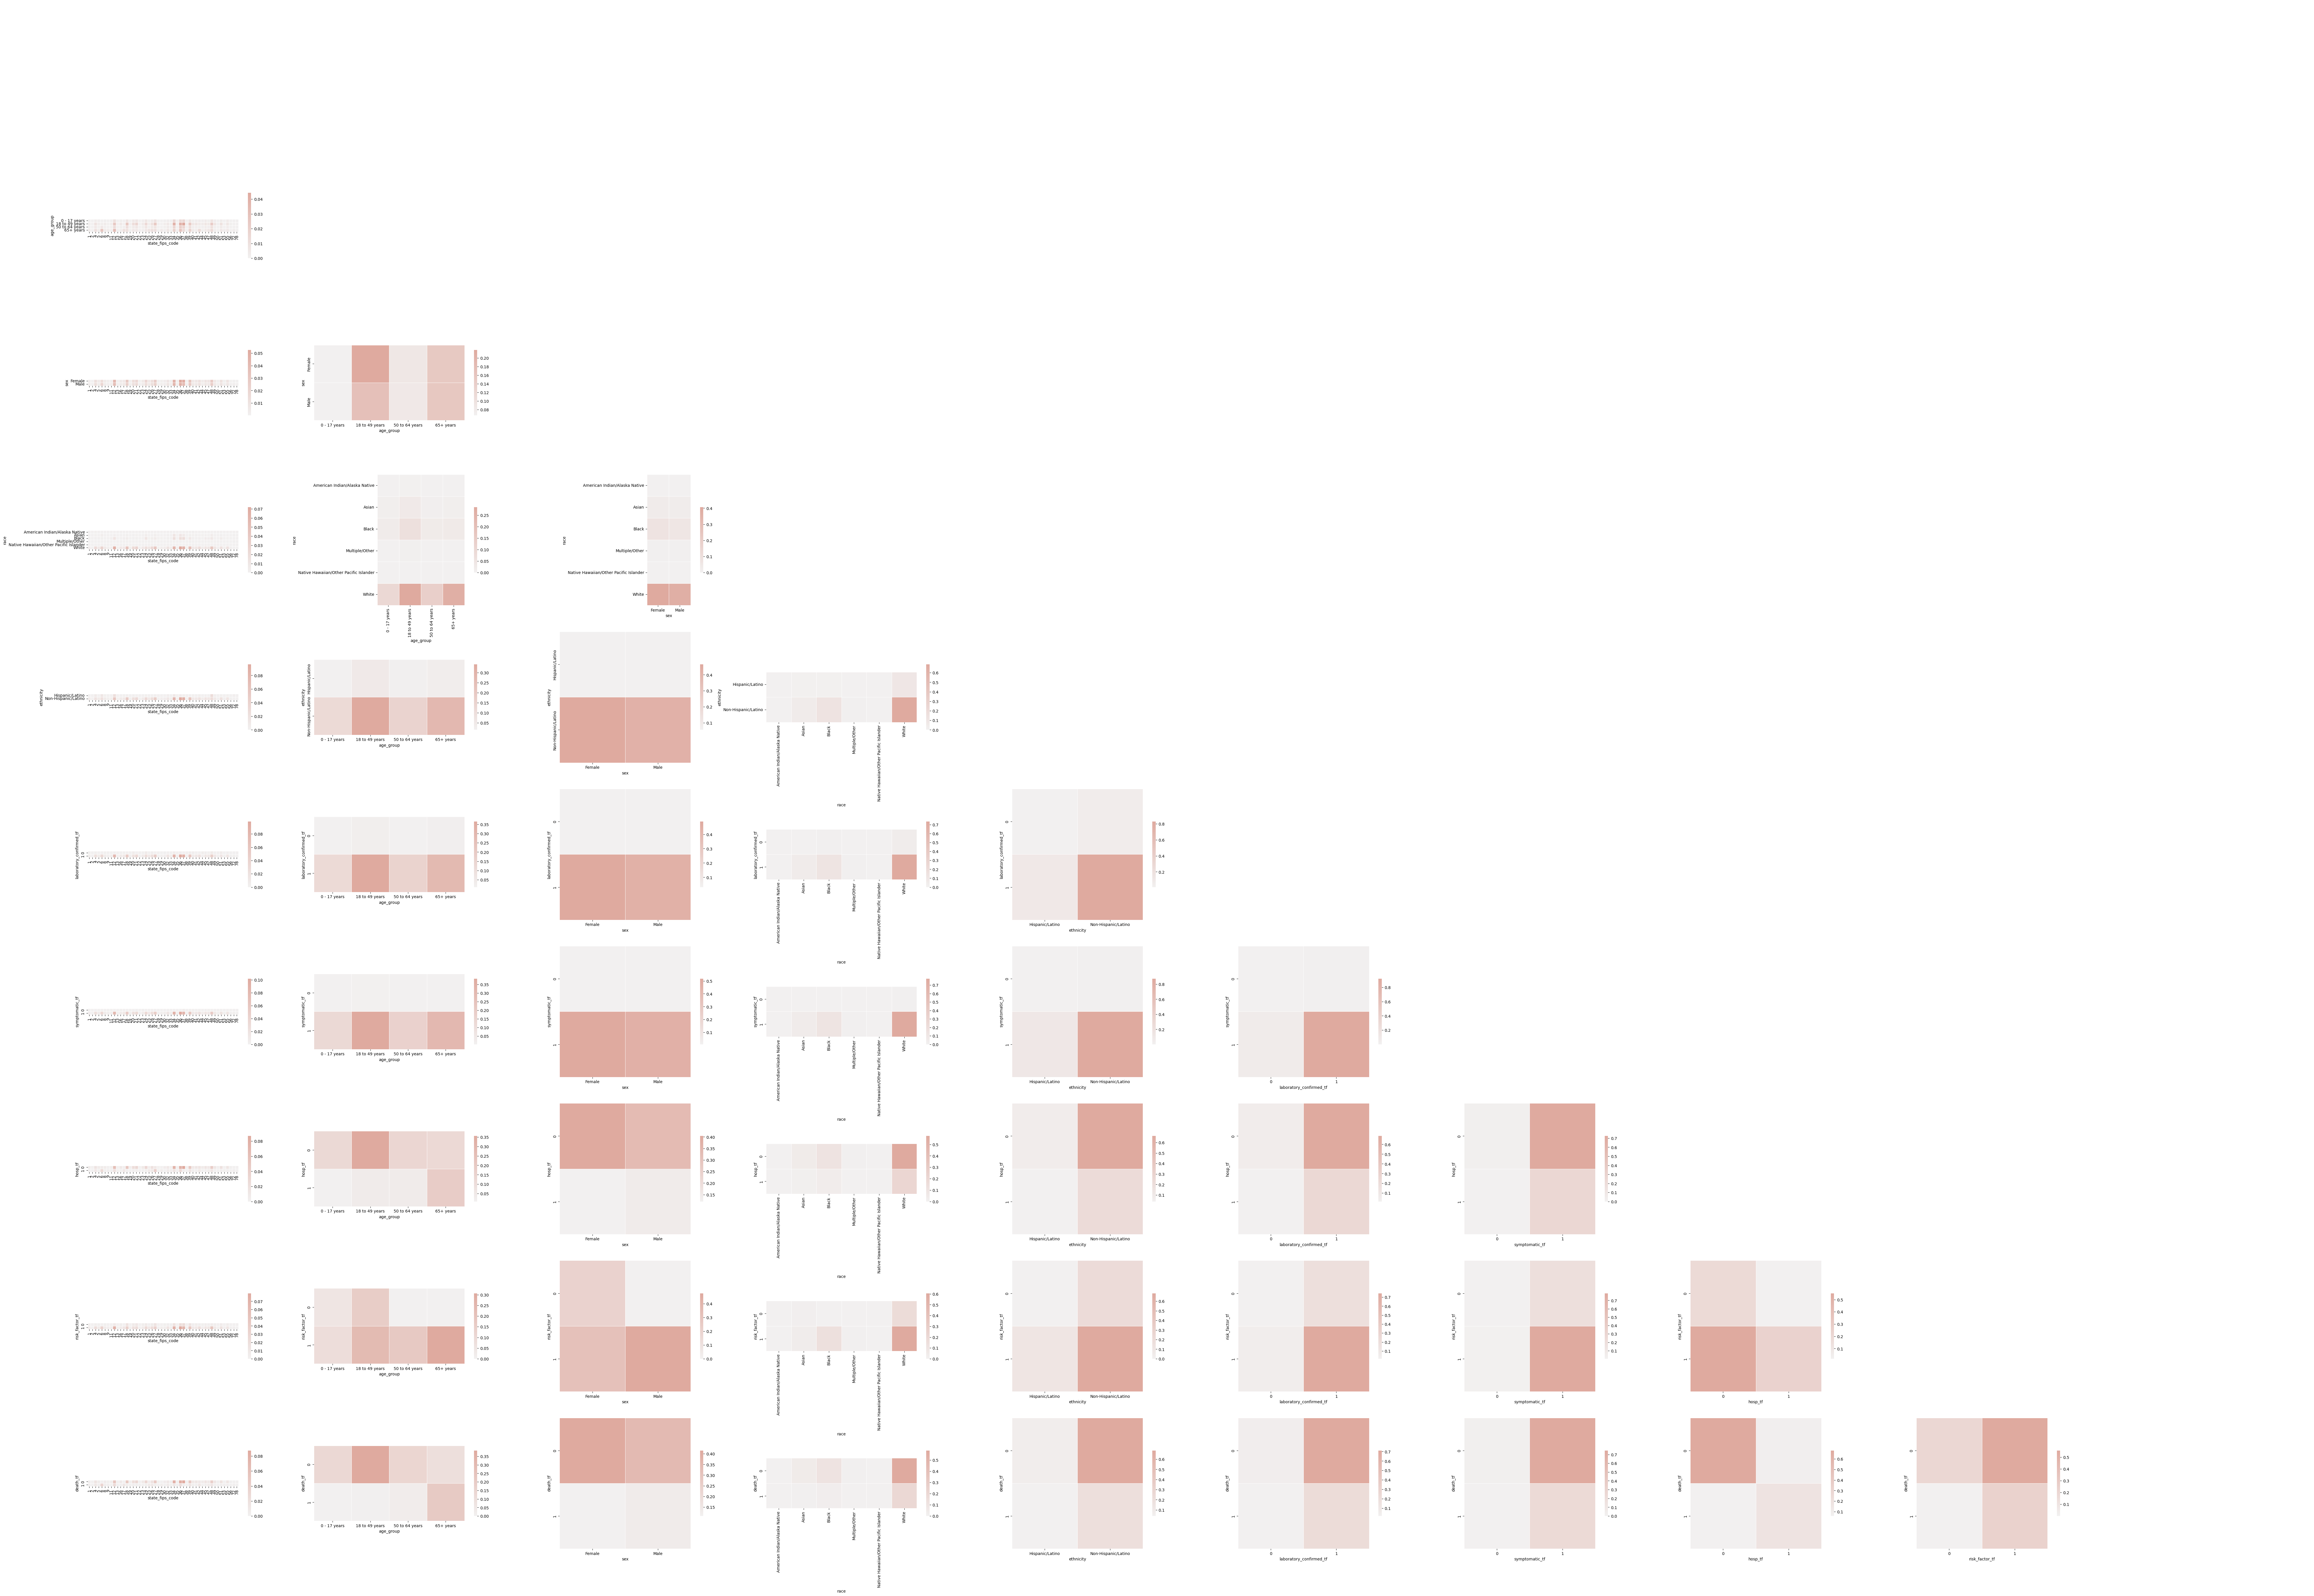

In [39]:
n = len(categorical)

fig, axs = plt.subplots(ncols=n, nrows=n, figsize=(100, 70))

for i, column_i in enumerate(categorical):
    for j, column_j in enumerate(categorical):
        if j < i:
            plotCrosstabHeatmap(data_training, column_i, column_j, axs[i][j])
        else:
            axs[i][j].axis('off')

##### Interpretation of the results
The plots allow us to visualize pairs of features which correlate strongly to each other; areas of the heatmap which are red correspond indicate that there are many patients which fall into that combination of categories, and areas which are cyan correspond to very few. However, there are a few limitations to this visualization, namely when it comes to sample size. If the sample size for one category (e.g., 'White' in the 'Race' feature) is significantly larger than others, it might dominate the heatmap. This makes it appear as though there are stronger associations for that category, even if those are merely due to the larger sample size. Because of this we will simply use this as a tool to understand distribution, rather than a guide for the prediction model.

**Observations**
- Some patient groups have more representation than others. These observations should match the analysis of the data from Task 1.
    - There are many more 'white' patients than non-white.
    - There are many more 'non-hispanic/latino' than 'hispanic/latino' patients.
    - There are many more 'laboratory-confirmed' patients than not.
    - There are many more 'symptomatic' patients than not.
    - There are fewer 'hospitlized' patients than not
- By design there is a correlation between risk factor and some of the other demographic groups. We will keep all of these features for now, but a potential optimization in Part 5 will be to drop either the demographic features or the risk factor feature.

**Features to Remove:** Keeping in mind the limitations stated on this visualization, we will not decide to remove any features based solely on this data.

#### **1.3.2.2 Categorical - Target Plots**
<li style="color: cyan; font-style: italic">For each categorical feature, plot its pairwise interaction with the target feature. Discuss what  knowledge you gain from these plots, e.g., which categorical features seem to be better at predicting the target feature? </li>

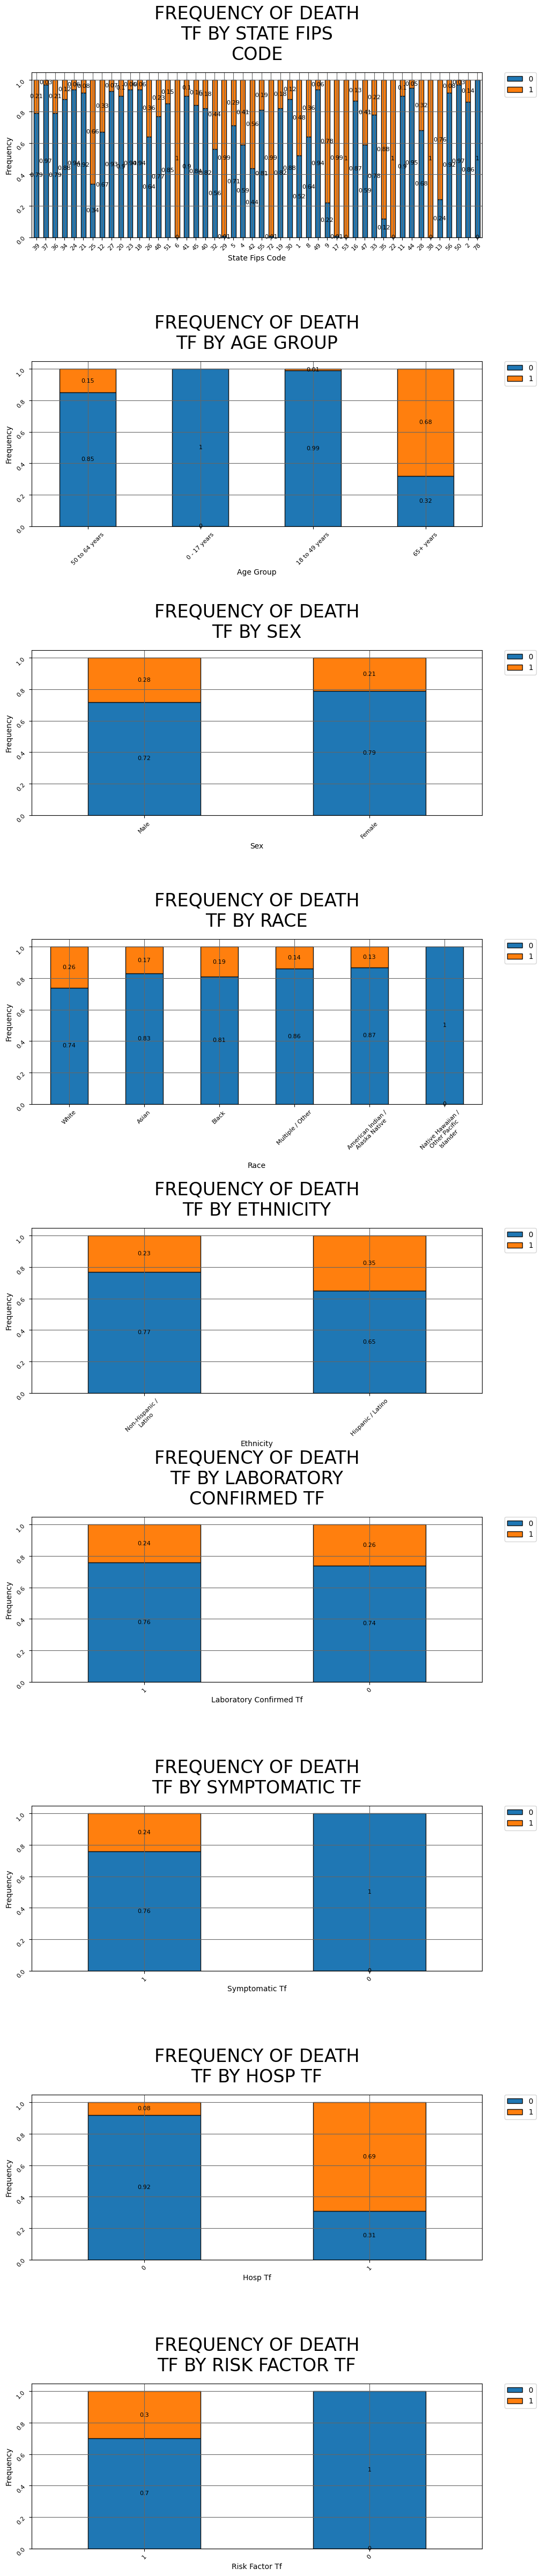

In [154]:
n = len(categorical)-1

fig, axs = plt.subplots(ncols=1, nrows=n, figsize=(6, 60))

for i, feature in enumerate(categorical):
    if feature != 'death_tf':
        createStackedBarChart(data_training, 'death_tf', feature, axs=axs[i] )

##### Interpretation of the results

The stacked bar charts seem to be better indicators of relationships between the features. We will briefly evaluate the relationship between each of the categorical features and death.

**State vs Death**
- Observations of the data reveal an unclear pattern between the state and the occurrence of death. However, it's noteworthy that in 12 states, over 50% of the COVID-19 cases in the study resulted in death.
- This could be due to various factors such as differing state-level responses, demographics, or access to healthcare facilities.
- Despite the lack of a clear pattern, we will retain this feature due to the potential for hidden relationships that might be discovered with further analysis.

**Age Group vs Death**
- There's a strong correlation between age group and death. The death rate for the 0-17 and 18-49 age groups is below 0.01%, but this increases dramatically to 15% for those aged 50-64 and surges to 68% for those aged 65 and above.
- This correlation is to be expected, since it is well known that age is a risk factor for death.
- We will definitely retain this feature due to its strong correlation with the target feature.

**Sex vs Death**
- There appears to be a slight correlation between sex and death. The death rate is 21% for females and 28% for males.
- We will retain this feature, as even slight correlations have the potential to improve the accuracy of the model.

**Race vs Death**
- There's a considerable range in the percentage of cases leading to death among different racial groups. The death rate for white patients is 26%, decreasing to 19% for black patients, 17% for Asian patients, 14% for others, 13% for American Indian/Alaska Natives, and 0% for Native Hawaiian.
- The observed variation might be related to the sample size or other social and health factors.
- We will retain this feature because of the potential for uncovering deeper insights.

**Ethnicity vs Death**
- A significant difference in the occurrence of death between Hispanic/Latino and non-Hispanic/Latino patients is observed, with Hispanic/Latino patients dying more often by 12%.
- We will retain this feature as it shows a notable difference in death rates.

**Laboratory Confirmed Case vs Death**
- The data shows that the proportion of patients who died with a laboratory-confirmed case is almost equal to the proportion of patients who died without a confirmed case - 24% and 26% respectively.
- This suggests that laboratory confirmation does not significantly impact the likelihood of death.
- Since the feature does not seem to provide valuable predictive power, we will not retain this feature.

**Symptomatic vs Death**
- The data reveals a significant correlation between being symptomatic and death, as no deaths were observed in asymptomatic patients.
- Given the absolute correlation, we will definitely retain this feature.

**Hospitalized vs Death**
- Another strong correlation is seen with hospitalization. Patients who were hospitalized died 69% of the time, compared to an 8% death rate for non-hospitalized patients.
- This is expected because hospitalization is typically indicative of more severe disease.
- We will retain this feature due to its strong correlation with the target feature.

**Risk Factor vs Death**
- The 'Risk Factor' feature, which is an aggregate of several other features, shows a notable correlation with death. No deaths were observed in patients with a risk factor of 0, while a death rate of 30% was noted among patients with a risk factor of 1.
- However, because this feature is a composite of several others, including it might introduce multicollinearity into our model. For this reason, we will include this feature for the moment, but consider eliminating it or the features it encapsulates in later optimization steps.

#### **1.3.2.3 Selection of Indicative Categorical Features**
The set of indicative categorical features we will be using includes the following:
* state_fips_code
* age_group
* sex
* ethnicity
* symptomatic_tf
* hosp_tf
* risk_factor_tf

The only categorical feature to be dropped will be laboratory_confirmed_case_tf

In [245]:
cat_low_correlation_features = ['laboratory_confirmed_tf']

### 1.3.3 Summary & Drop Features

1. The continuous features to be dropped, identified in 1.3.1.4 are as follows:


In [246]:
cont_low_correlation_features

['case_onset_interval']


2. The categorical features to be dropped, identified in 1.3.2.3 are as follows:

In [247]:
cat_low_correlation_features

['laboratory_confirmed_tf']

We will now drop these features
- Before dropping the features, we will duplicate the original dataframe, data_cleaned, and label it model_data
- We will drop the features from model_data, allowing us to revert back to the original dataset when we want to compare the performance of our new dataset with the original.

In [248]:
# Copy the data frame
model_data = data_cleaned.copy()
# Concatenate the list of features to drop
features_to_drop = cont_low_correlation_features + cat_low_correlation_features
# Drop the features
model_data = model_data.drop(columns=features_to_drop)

# Print the new dataframe
model_data.head(10)

,case_month,state_fips_code,age_group,sex,race,ethnicity,case_positive_specimen_interval,symptomatic_tf,hosp_tf,death_tf,income,people_vaccinated,risk_factor_tf
0,2020-11-01,32,65+ years,Female,White,Non-Hispanic/Latino,2,1,1,1,59340,0,1
1,2021-08-01,4,50 to 64 years,Male,White,Hispanic/Latino,3,1,0,1,64468,206797098,1
2,2020-12-01,12,65+ years,Male,White,Non-Hispanic/Latino,0,1,1,1,52828,5566951,1
3,2020-12-01,6,65+ years,Female,White,Non-Hispanic/Latino,2,1,1,1,68044,5566951,1
4,2020-11-01,48,65+ years,Male,White,Hispanic/Latino,0,1,1,1,57157,0,1
5,2020-08-01,1,65+ years,Female,White,Non-Hispanic/Latino,0,1,1,1,47583,0,1
6,2021-09-01,16,65+ years,Male,White,Non-Hispanic/Latino,0,1,1,1,52134,215360247,1
7,2021-11-01,39,65+ years,Female,White,Non-Hispanic/Latino,1,1,1,1,57618,233824494,1
8,2020-12-01,49,65+ years,Male,White,Non-Hispanic/Latino,0,1,0,1,74865,5566951,1
9,2021-01-01,12,65+ years,Female,White,Hispanic/Latino,0,1,1,1,51347,29890726,1


## 1.4 Prepare Dataset for Modeling

We have now identified the features that we want to use in our predictive models.To prepare them for modeling, we will need to convert all categorical features into dummy variables or integers to allow modeling. We will be using one-hot/dummy encoding for sex, race, and ethnicity, and we will use integer encoding for age_group (where it makes sense to preserve the order of categories). The remaining categorical features have already been converted to binary 0 or 1 values, and will not need to be converted for modeling, but we will convert them to uint8 types for memory efficiency. The other integer encoding we will need to do is converting the datetime variable for case_month into a representative integer.

### 1.4.1 Integer encoding

In [249]:
# Integer encoding of age group
model_data['age_group'] = model_data['age_group'].map({'65+ years': 3, '50 to 64 years': 2, '18 to 49 years': 1, '0 - 17 years': 0}).astype('uint8')

# List boolean values in our dataset to be converted to uint8, then converted
model_data_boolean_values = ['symptomatic_tf', 'hosp_tf', 'death_tf', 'risk_factor_tf']
model_data[model_data_boolean_values] = model_data[model_data_boolean_values].astype('uint8')

# Print datatypes
model_data.dtypes


case_month                         datetime64[ns]
state_fips_code                             uint8
age_group                                   uint8
sex                                      category
race                                     category
ethnicity                                category
case_positive_specimen_interval             int64
symptomatic_tf                              uint8
hosp_tf                                     uint8
death_tf                                    uint8
income                                      int64
people_vaccinated                           int64
risk_factor_tf                              uint8
dtype: object

In [250]:
# Integer encoding of case_month column
# Get first case month
min_date = model_data['case_month'].min()
# Subtract min_date from each date in 'case_month', the result will be a datetime.timedelta object
model_data['case_month'] = model_data['case_month'] - min_date
# Convert the timedelta object to number of days and then to months
model_data['case_month'] = (model_data['case_month'] / np.timedelta64(1, 'M')).astype('int64')

# Print datatypes
model_data.dtypes


case_month                            int64
state_fips_code                       uint8
age_group                             uint8
sex                                category
race                               category
ethnicity                          category
case_positive_specimen_interval       int64
symptomatic_tf                        uint8
hosp_tf                               uint8
death_tf                              uint8
income                                int64
people_vaccinated                     int64
risk_factor_tf                        uint8
dtype: object

### 1.4.2 Dummy Encoding

In [251]:
model_data = pd.get_dummies(model_data)
model_data.dtypes

case_month                                     int64
state_fips_code                                uint8
age_group                                      uint8
case_positive_specimen_interval                int64
symptomatic_tf                                 uint8
hosp_tf                                        uint8
death_tf                                       uint8
income                                         int64
people_vaccinated                              int64
risk_factor_tf                                 uint8
sex_Female                                     uint8
sex_Male                                       uint8
race_American Indian/Alaska Native             uint8
race_Asian                                     uint8
race_Black                                     uint8
race_Multiple/Other                            uint8
race_Native Hawaiian/Other Pacific Islander    uint8
race_White                                     uint8
ethnicity_Hispanic/Latino                     

#### Redundant Features
We do not need to keep sex_Male or ethnicity_Non-Hispanic/Latino, since these implied with the falseness of sex_Female and ethnicity_Hispanic/Latino respectively.

In [252]:
model_data = model_data.drop(columns=['sex_Male','ethnicity_Non-Hispanic/Latino'])

### 1.4.3 Summary
#### Continuous Columns are:

In [253]:
continuous_columns = model_data.select_dtypes(include=['int64']).columns.tolist()
continuous_columns

['case_month',
 'case_positive_specimen_interval',
 'income',
 'people_vaccinated']

##### Categorical Columns are:

In [254]:
categorical_columns = model_data.select_dtypes(include=['uint8']).columns.tolist()
categorical_columns

['state_fips_code',
 'age_group',
 'symptomatic_tf',
 'hosp_tf',
 'death_tf',
 'risk_factor_tf',
 'sex_Female',
 'race_American Indian/Alaska Native',
 'race_Asian',
 'race_Black',
 'race_Multiple/Other',
 'race_Native Hawaiian/Other Pacific Islander',
 'race_White',
 'ethnicity_Hispanic/Latino']

##### Total features are:

In [256]:
features = continuous_columns + categorical_columns
features

['case_month',
 'case_positive_specimen_interval',
 'income',
 'people_vaccinated',
 'state_fips_code',
 'age_group',
 'symptomatic_tf',
 'hosp_tf',
 'death_tf',
 'risk_factor_tf',
 'sex_Female',
 'race_American Indian/Alaska Native',
 'race_Asian',
 'race_Black',
 'race_Multiple/Other',
 'race_Native Hawaiian/Other Pacific Islander',
 'race_White',
 'ethnicity_Hispanic/Latino']

### 1.4.4 Train/Test Split

Repeat the process of splitting the data into testing and training data

In [258]:
# Load the dataset into a pandas dataframe and set X and y
descriptive_features = ['case_month', 'case_positive_specimen_interval', 'income', 'people_vaccinated', 'state_fips_code', 'age_group', 'symptomatic_tf', 'hosp_tf', 'risk_factor_tf', 'sex_Female', 'race_American Indian/Alaska Native', 'race_Asian', 'race_Black', 'race_Multiple/Other', 'race_Native Hawaiian/Other Pacific Islander', 'race_White', 'ethnicity_Hispanic/Latino']
target_feature = ['death_tf'] 

X = model_data[descriptive_features]
y = model_data[target_feature]

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

print("original range is:\t rows 0 to", data_cleaned.shape[0])
print("training range (70%):\t rows 0 to", round(data_training.shape[0]))
print("test range (30%): \t rows", round(data_training.shape[0]), "to", round(data_training.shape[0]) + data_testing.shape[0])

original range is:	 rows 0 to 37940
training range (70%):	 rows 0 to 26558
test range (30%): 	 rows 26558 to 37940


We can see from the X_train printout below that the indexes are no longer consecutive. We need to reset the indices in order to enable merging of the datasets later on.

In [259]:
X_train.head(5)

,case_month,case_positive_specimen_interval,income,people_vaccinated,state_fips_code,age_group,symptomatic_tf,hosp_tf,risk_factor_tf,sex_Female,race_American Indian/Alaska Native,race_Asian,race_Black,race_Multiple/Other,race_Native Hawaiian/Other Pacific Islander,race_White,ethnicity_Hispanic/Latino
4635,13,0,49547,108794662,39,2,1,0,1,0,0,0,0,0,0,1,0
8065,3,0,51569,0,37,2,1,0,1,1,0,0,0,0,0,1,1
11826,24,0,49994,251497361,37,0,1,0,0,1,0,0,0,0,0,1,0
12852,20,0,65499,222028571,36,1,1,0,1,0,0,0,0,0,0,1,0
14120,11,0,60955,5566951,37,3,1,0,1,0,0,0,0,0,0,1,0


In [260]:
# need to reset the index to allow contatenation with predicted values otherwise not joining on same index...
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)
X_train.head(5)

,case_month,case_positive_specimen_interval,income,people_vaccinated,state_fips_code,age_group,symptomatic_tf,hosp_tf,risk_factor_tf,sex_Female,race_American Indian/Alaska Native,race_Asian,race_Black,race_Multiple/Other,race_Native Hawaiian/Other Pacific Islander,race_White,ethnicity_Hispanic/Latino
0,13,0,49547,108794662,39,2,1,0,1,0,0,0,0,0,0,1,0
1,3,0,51569,0,37,2,1,0,1,1,0,0,0,0,0,1,1
2,24,0,49994,251497361,37,0,1,0,0,1,0,0,0,0,0,1,0
3,20,0,65499,222028571,36,1,1,0,1,0,0,0,0,0,0,1,0
4,11,0,60955,5566951,37,3,1,0,1,0,0,0,0,0,0,1,0


The datasets are now ready for modeling!

# **2.0 Predictive Modeling: Linear Regression** 

## 2.1 Train the Linear Regression Model
<span style="color: cyan; font-style:italic;">On the training set, train a linear regression model to predict the target feature, using only the  descriptive features selected in exercise (1) above. </span>

In [263]:
# Train aka fit, a model using all continuous and categorical features.
multiple_linreg = LinearRegression().fit(X_train, y_train)

## 2.2 Interpret the Linear Regression Model

<div style="color: lightgreen">

- Linear regression is a modeling tool that is used to make predictions based on linear relationship between the target (dependent variable) and any number of predictors (independent variables)
    - It finds the line of best fit the describes the relationship between the target and predictors 
    - This line is calculated by minimising the overall error
- The linear regression formula takes the following form:
    - $target\_feature = w_0 + w_1 * feature_1 + w_2*feature_2 + ...+ w_n*feature_n $
    - The output of this formula will be a continuous value that can be less than 0 and higher than 1
- We can see the calculated intercept is -0.86 (w_0)
    - This is the starting point. i.e. if all other coefficients are zero then the model result will be -0.86
    - Can be thought of as where the model line intercepts the y axis
- We can see all the coefficients for each feature
    - These are zipped together in a single list for ease of inspection.
    - The sum of all the feature*coefficients + intercept will result in the model prediction  
- We cannot make a direct comparison based on the value of the coefficients as it is tied directly to the range of each feature.
    - If all features were normalized this would be possible to see directly
    - However if we multiply each feature by its max range we can get an idea of its max possible impact on the prediction.  We could look at median also.
    - For ExternalRiskEstimate its max is 93 (93 * 0.0147 = 1.367)
    - For PercentTradesNeverDelq its max is 100 (100 * -0.0024 = 0.24)
    - From this we can see that ExternalRiskEstimate can have a bigger impact than PercentTradesNeverDelq. 
    - This should correspond roughly with the correlation values from part 1   
    
It is important to note that the output from a linear regression model is not suited to the classification problem that we are trying to solve.
- The output is not a probability and an additional thresholding step is necessary to convert the output into a binary classification
- We will threshold the output so that any values >=0.5 will be cast to 1, any values <0.5 will be cast to 0

Finally it is worth mentioning the effect outliers can have on linear regression output. 
- Consider the effect of the outlier in the graph below on the regression line and what values fall into each threshold category. 
- The outlier will have a huge effect on values near the threshold. 
- This will be discussed further in the next section. <br>
<img src="linear_regression_outliers.png"> <br>
source: https://medium.com/@rgotesman1/learning-machine-learning-part-3-logistic-regression-94db47a94ea3

</div>


### **Coefficients**
<span style="color: cyan; font-style: italic;">  Print the coefficients learned by the model and discuss their role in the model (e.g., interpret the model by analysing each coefficient and how it relates each input feature to the target feature).  </span>


In [264]:
# Print the weights learned for each feature.
print("\nFeatures are: \n", X_train.columns)
print("\nCoefficients are: \n", multiple_linreg.coef_)
print("\nIntercept is: \n", multiple_linreg.intercept_)
print("\nFeatures and coefficients: \n", list(zip(X_train.columns, multiple_linreg.coef_)))


Features are: 
 Index(['case_month', 'case_positive_specimen_interval', 'income',
       'people_vaccinated', 'state_fips_code', 'age_group', 'symptomatic_tf',
       'hosp_tf', 'risk_factor_tf', 'sex_Female',
       'race_American Indian/Alaska Native', 'race_Asian', 'race_Black',
       'race_Multiple/Other', 'race_Native Hawaiian/Other Pacific Islander',
       'race_White', 'ethnicity_Hispanic/Latino'],
      dtype='object')

Coefficients are: 
 [[-1.12292410e-02  5.85956496e-05 -6.66062140e-07  3.72536289e-10
  -2.00932114e-03  1.82557735e-01  7.70879721e-02  3.63868600e-01
  -4.83319303e-02 -4.82171489e-02 -4.37374755e-02  5.97765131e-03
   1.13378727e-02 -1.11739182e-03  4.12363696e-02 -1.36970263e-02
   9.18035363e-02]]

Intercept is: 
 [0.06890771]

Features and coefficients: 
 [('case_month', array([-1.12292410e-02,  5.85956496e-05, -6.66062140e-07,  3.72536289e-10,
       -2.00932114e-03,  1.82557735e-01,  7.70879721e-02,  3.63868600e-01,
       -4.83319303e-02, -4.82171489

### **Target Feature Values and Predicted Class**
<span style="color: cyan; font-style: italic;">  Print the predicted target feature value for the first 10 training examples. Threshold the predicted target feature value given by the linear regression model at 0.5, to get the predicted class for each example. Print the predicted class for the first 10 examples.</span>

<div style="color: lightgreen">

- Here we will print the predicted target feature value for the first 100 training examples. 
- We will threshold the predicted target feature value given by the linear regression model at 0.5, to get the predicted class for each example. 
    - If value is >= 0.5 it is cast to 1, if < 0.5 it is cast to 0

</div>

In [265]:
# calculate the prediction and threshold the value. If >= 0.5 its true
multiple_linreg_predictions_train = (multiple_linreg.predict(X_train) >= 0.5) * 1.0

print("\nPredictions with multiple linear regression: \n")
actual_vs_predicted_multiplelinreg = pd.concat([y_train, pd.DataFrame(multiple_linreg_predictions_train, columns=['Predicted'])], axis=1)
print(actual_vs_predicted_multiplelinreg.head(100))


Predictions with multiple linear regression: 

    death_tf  Predicted
0          0        0.0
1          0        0.0
2          0        0.0
3          0        0.0
4          0        0.0
..       ...        ...
95         0        0.0
96         0        0.0
97         0        0.0
98         0        0.0
99         0        0.0

[100 rows x 2 columns]


### **Classification Evaluation Measures on Training Set**
<span style="color: cyan; font-style: italic;">   Print a few classification evaluation measures computed on the full training set (e.g., Accuracy, Confusion matrix, Precision, Recall, F1)</span>

<div style="color: lightgreen">

- We will print the classification evaluation measures computed on the training set (e.g. Accuracy, Confusion matrix, Precision, Recall, F1)
- We will discuss findings based on these measures

</div>

In [266]:
# Some more evaluation metrics.
print("==================== Train Data =======================")
print("Accuracy: ", metrics.accuracy_score(y_train, multiple_linreg_predictions_train))
print("Confusion matrix: \n", metrics.confusion_matrix(y_train, multiple_linreg_predictions_train))
print("Classification report:\n ", metrics.classification_report(y_train, multiple_linreg_predictions_train))
print("======================================================")

==================== Train Data =======================
Accuracy:  0.8992394005572709
Confusion matrix: 
 [[19032  1158]
 [ 1518  4850]]
Classification report:
                precision    recall  f1-score   support

           0       0.93      0.94      0.93     20190
           1       0.81      0.76      0.78      6368

    accuracy                           0.90     26558
   macro avg       0.87      0.85      0.86     26558
weighted avg       0.90      0.90      0.90     26558



### **Interpretation of the Results**
<span style="color: cyan; font-style: italic"> discuss your findings so far. </span>

<div style="color: lightgreen">

- Accuracy
    - This is simply stating how often the model is correct. We have an accuracy of 73%
- Confusion Matrix
    - [0][0] TRUE NEGATIVE - The number that is predicted 0 that was actually 0
    - [0][1] FALSE POSITIVE - The number that is predicted 1 that is actually 0
    - [1][0] FALSE NEGATIVE - The number that is predicted 0 that is actually 1
    - [1][1] TRUE POSITIVE - The number that is predicted 1 that is actually 1
- Precision - How good the model is at predicting the positive class
    - What % of the predicted positive are actually positive
    - It is the number values correctly predicted positive over the total number of  positive values
    - Precision Positive is 0.72
    - Precision Negative is 0.75
- Recall
    - What % of the positive values did we predict
    - Is the number correctly predicted positive over the total number actual positive
    - Recall Positive is 0.68
    - Recall Negative is 0.78
- F1 Score
    - Is an a weighted average of Precision and recall
    - F1 Score Positive is 0.70
    - F1 Score Negative is 0.77

Summary
- Theses values seem reasonable. 
- The model is a little better at predicting the negative class.
- This makes sense as the model has more negative data to learn from - it is the majority class. 
- This is ideal as it suits the business requirement of flagging potential defaulters more accurately.
- It is better that a credit institution overestimates the number of possible defaulters then underestimates. 
- The down side of this is more people who will not actually default will be flagged 

</div>

## 2.3 Evaluate the Linear Regression Model

### **Classification Evaluation Measures on the Testing Set**
<span style="color: cyan; font-style: italic"> Evaluate the model using classification evaluation measures on the hold-out (30% examples) test set. Compare these results with the evaluation results obtained on the training (70%) dataset. </span>

<div style="color: lightgreen">

- The results from the test data will be compared the results from the training data.
- In addition they will be compared to the results from a cross-validated model (i.e. a new model trained and evaluated using cross-validation on the full dataset).

</div>

In [267]:
# calculate the prediction and threshold the value. If >= 0.5 its true
multiple_linreg_predictions_test = (multiple_linreg.predict(X_test) >= 0.5) * 1.0

print("\nPredictions with multiple linear regression: \n")
actual_vs_predicted_multiplelinreg = pd.concat([y_test, pd.DataFrame(multiple_linreg_predictions_test, columns=['Predicted'])], axis=1)
print(actual_vs_predicted_multiplelinreg.head(100))


Predictions with multiple linear regression: 

    death_tf  Predicted
0          0        0.0
1          0        0.0
2          1        1.0
3          0        0.0
4          0        0.0
..       ...        ...
95         1        1.0
96         1        1.0
97         0        0.0
98         0        0.0
99         0        1.0

[100 rows x 2 columns]


In [268]:
# Some more evaluation metrics.
print("==================== Test Data =======================")
print("Accuracy: ", metrics.accuracy_score(y_test, multiple_linreg_predictions_test))
print("Confusion matrix: \n", metrics.confusion_matrix(y_test, multiple_linreg_predictions_test))
print("Classification report - Test data:\n ", metrics.classification_report(y_test, multiple_linreg_predictions_test))
print("\n==================== Train Data ======================")
print("Accuracy: ", metrics.accuracy_score(y_train, multiple_linreg_predictions_train))
print("Confusion matrix: \n", metrics.confusion_matrix(y_train, multiple_linreg_predictions_train))
print("\nClassification report: - Training data\n ", metrics.classification_report(y_train, multiple_linreg_predictions_train))

==================== Test Data =======================
Accuracy:  0.9027411702688456
Confusion matrix: 
 [[8117  467]
 [ 640 2158]]
Classification report - Test data:
                precision    recall  f1-score   support

           0       0.93      0.95      0.94      8584
           1       0.82      0.77      0.80      2798

    accuracy                           0.90     11382
   macro avg       0.87      0.86      0.87     11382
weighted avg       0.90      0.90      0.90     11382


==================== Train Data ======================
Accuracy:  0.8992394005572709
Confusion matrix: 
 [[19032  1158]
 [ 1518  4850]]

Classification report: - Training data
                precision    recall  f1-score   support

           0       0.93      0.94      0.93     20190
           1       0.81      0.76      0.78      6368

    accuracy                           0.90     26558
   macro avg       0.87      0.85      0.86     26558
weighted avg       0.90      0.90      0.90     26558

<div style="color: lightgreen;">

**Interpretation of test results and comparison with training results**
- Accuracy
    - The accuracy of the test data is marginally higher 73.52% vs 73.47%. 
- Precision
    - The precision score for predicting the positive case has reduced from 72% to 70%.
    - The precision score for predicting the negative case has increased from 75% to 77%.
- Recall
    - The recall score for predicting the positive case has increased from 67% to 73%.
    - The recall score for predicting the negative case has reduced from 79% to 74%.
- F1
    - The f1 score for predicting the positive case has increased from 69% to 72%.
    - The f1 score for predicting the negative case has reduced from 77% to 75%.

**Summary**
- These values are a little higher than expected as we are now testing the model prediction on data it has not seen before
- This is a good sign that the model is generalising
- More comparisons need to be made and this is where cross validation steps in 
</div>



### **Classification Evaluation Measures on Cross-Validated Set**
<span style="color: cyan; font-style: italic"> Also compare these results with a cross-validated model (i.e., a new model trained and evaluated using cross-validation on the full dataset). You can use classic k-fold cross-validation or repeated random train/test (70/30) splits. </span>

<div style="color: lightgreen">
- We will now perform cross validation on the linear regression model. 
- Here we perform the same evaluation as above but multiple times
- Each time the data is shuffled so we get a slightly different view of the data for training and testing
- This works well for evaluating on a limited set of data
- We will store the results in a dictionary for later use

First we need to create a function to perform this cross validation. Sklearn does not provide one for linear regression. However it does for logistic and random forests models
- Cross validation Function can be seen below

</div>

In [269]:
def cross_val_LinReg(X, y, cv=3, scoring='accuracy'):
    """Functions to carry out cross validation on the linear regression model
    Default number of validations is 3. The random state will be updated 
    at each iteration to allow our results to be repeated"""
    
    # store results
    results = []
    # evaluate cv times and append to results
    for i in range(cv):
        # set up train test split
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=i , test_size=0.3)
        # generate model
        multiple_linreg = LinearRegression().fit(X_train, y_train)
        # threshold
        multiple_linreg_predictions = (multiple_linreg.predict(X_test) >= 0.5) * 1.0
        # calc score
        if scoring=='accuracy':
            score = metrics.accuracy_score(y_test, multiple_linreg_predictions)
        elif scoring=='precision':
            score = metrics.precision_score(y_test, multiple_linreg_predictions)
        elif scoring=='f1':
            score = metrics.f1_score(y_test, multiple_linreg_predictions)
        elif scoring=='recall':
            score = metrics.recall_score(y_test, multiple_linreg_predictions)
        # append to results
        results.append(score)
    return results

<div style="color: lightgreen">

We will now create an additional function to perform 10 fold cross validation and store results into a dataframe
- This will be used to simplify further analysis the dataset, looking at accuracy, precision, recall, f1.

</div>

In [270]:
def cross_val_LinReg_DF(X,y):
    """Function to perform cross validation and store results 
    in dataframe. Cross validation looks at accuracy, precision, 
    recall, f1. Returns a dataframe with results"""

    linRegResults = {}
    # metrics to test against
    test_metrics = ['accuracy','precision','recall', 'f1']
    
    for metric in test_metrics:
        # generate test results
        result = cross_val_LinReg(X, y, cv=10, scoring=metric)
        length = len(result)
        # store result in dict
        linRegResults[metric] = sum(result)/length

    # create dataframe with results
    LinRegDF = pd.DataFrame.from_dict(linRegResults, orient='index', columns=['Linear_Regression'])
    
    return LinRegDF

<div style="color: lightgreen">

Perform 10 fold cross validation using cross_val_LinReg_DF function
- Results summarized below

</div>

In [271]:
linRegDF = cross_val_LinReg_DF(X,y)
print(f"Mean results from 10 fold cross validation are:")
linRegDF

Mean results from 10 fold cross validation are:


,Linear_Regression
accuracy,0.901151
precision,0.814227
recall,0.765365
f1,0.789028




### **Interpretation of the Results**
<span style="color: cyan; font-style: italic"> Compare the cross-validation metrics to those obtained on the single train/test split and discuss your findings. </span>

<div style="color: lightgreen">These results are marginally lower than previous results but this is expected. We have taken the mean of 10 sets of results. </div>

# **3.0 Predictive Modeling: Logistic Regression** 

## 3.1 Train the Logistic Regression Model
<span style="color: cyan; font-style:italic;">On the training set, train a logistic regression model to predict the target feature, using only the  descriptive features selected in exercise (1) above. </span>


In [297]:
# Train aka fit, a model using all continuous and categorical features.
multiple_logisticreg = LogisticRegression().fit(X_train, y_train)


## 3.2 Interpret the Logistic Regression Model

<div style="color: lightgreen">

The logistic regression function is a little different than the linear regression function. 
- The output of the logistic function is a probability, a value between 0 and 1
- The output of the linear function is a continuous value that is not a probability
- Differences aside there is a direct relationship between the two
    - The first part of logistic regression function is similar to linear regression i.e. We find the line of best fit
    - We then pass this equation through what is called a sigmoid function
    - This sigmoid function will output a value bound between 0 and 1. It is a probability
    - The model then applies a threshold to this probability so that if is is >= 0.5 its cast to 1 and if it is <0.5 it is cast to 0
    - All of these steps are carried out within the logistic regression function, however the threshold value can be adjusted up or down depending on the problem you are trying to solve.

The model estimated in logistic regression is given by the logistic function: <br>
$probability(target=1|descriptive\_features)=logistic(w_0 + w_1 * feature_1 + w_2*feature_2 + ...+ w_n*feature_n)$ <br>
where $logistic(x)$ is defined as: $logistic(x) = \frac{e ^ x}{1 + e ^ x} = \frac{1}{1+e^{-x}}$

- From the values above can see the calculated intercept is -1.006
    - This is the starting point. i.e. if all other coefficients were zero then the value for 'x' would be -1.006. 
    - This is the input to the logistic function and the logistic function will then calculate the probability and threshold based on this.
- We can see all the coefficients for each features
    - These are zipped together in a single list for ease of inspection.
    - The effect of these on the value 'x' is the same as for linear regression
    - Only when the value 'x' is fed into the logistic function do we see the real difference between the to methods.
    
A major benefit of logistic regression worth  highlighting is its ability to handle outliers. 
- As discussed for linear regression, outliers can significantly skew what values fall within each threshold point. 
- The graph below highlights the minimal effect outliers can have on logistic regression model.
- Values near the threshold point will not be impacted significantly<br>
<img src="logistic_regression_outliers.png"> <br>
Source: https://towardsdatascience.com/understanding-logistic-regression-9b02c2aec102

</div>

### **Coefficients**
<span style="color: cyan; font-style: italic;">  Print the coefficients learned by the model and discuss their role in the model (e.g., interpret the model by analysing each coefficient and how it relates each input feature to the target feature).  </span>

In [298]:
# Print the weights learned for each feature.
print("\nFeatures are: \n", X_train.columns)
print("\nCoefficients are: \n", multiple_logisticreg.coef_[0])
print("\nIntercept is: \n", multiple_logisticreg.intercept_)
print("\nFeatures and coefficients: \n", list(zip(X_train.columns, multiple_logisticreg.coef_[0])))


Features are: 
 Index(['case_month', 'case_positive_specimen_interval', 'income',
       'people_vaccinated', 'state_fips_code', 'age_group', 'symptomatic_tf',
       'hosp_tf', 'risk_factor_tf', 'sex_Female',
       'race_American Indian/Alaska Native', 'race_Asian', 'race_Black',
       'race_Multiple/Other', 'race_Native Hawaiian/Other Pacific Islander',
       'race_White', 'ethnicity_Hispanic/Latino'],
      dtype='object')

Coefficients are: 
 [-1.14118977e-09 -2.55934433e-11 -7.30754865e-06 -5.63468976e-09
 -4.98392438e-09  3.78610561e-10 -9.27506942e-11  2.01716670e-10
  6.69546253e-12 -8.67369549e-11 -1.72177372e-12 -1.39520007e-11
 -2.79838098e-11 -2.65376915e-12 -5.00681169e-14 -5.67833020e-11
  3.62208145e-12]

Intercept is: 
 [-1.03144724e-10]

Features and coefficients: 
 [('case_month', -1.1411897684945094e-09), ('case_positive_specimen_interval', -2.559344333464469e-11), ('income', -7.307548653946498e-06), ('people_vaccinated', -5.634689755481701e-09), ('state_fips_cod


### **Target Feature Values and Predicted Class**
<span style="color: cyan; font-style: italic;">  Print the predicted target feature value for the first 10 training examples. Threshold the predicted target feature value given by the linear regression model at 0.5, to get the predicted class for each example. Print the predicted class for the first 10 examples.</span>

<div style="color: lightgreen">
- Here we will print the predicted target feature value for the first 100 training examples based on training data
</div>


In [299]:
# calculate the prediction and threshold the value. If >= 0.5 its true
multiple_logisticreg_predictions_train = multiple_logisticreg.predict(X_train)

print("\nPredictions with multiple linear regression: \n")
actual_vs_predicted_multiplelogisticreg = pd.concat([y_train, pd.DataFrame(multiple_logisticreg_predictions_train, columns=['Predicted'])], axis=1)
print(actual_vs_predicted_multiplelogisticreg.head(100))


Predictions with multiple linear regression: 

    death_tf  Predicted
0          0          0
1          0          0
2          0          0
3          0          0
4          0          0
..       ...        ...
95         0          0
96         0          0
97         0          0
98         0          0
99         0          0

[100 rows x 2 columns]



### **Classification Evaluation Measures on Training Set**
<span style="color: cyan; font-style: italic;">   Print a few classification evaluation measures computed on the full training set (e.g., Accuracy, Confusion matrix, Precision, Recall, F1)</span>

<div style="color:lightgreen"> 

- We will print the classification evaluation measures computed on the training set (e.g. Accuracy, Confusion matrix, Precision, Recall, F1)
- We will discuss finding based on these measures
</div>

In [300]:
# Some more evaluation metrics.
print("==================== Train Data =======================")
print("Accuracy: ", metrics.accuracy_score(y_train, multiple_logisticreg_predictions_train))
print("Confusion matrix: \n", metrics.confusion_matrix(y_train, multiple_logisticreg_predictions_train))
print("Classification report:\n ", metrics.classification_report(y_train, multiple_logisticreg_predictions_train, zero_division=1))
print("======================================================")

==================== Train Data =======================
Accuracy:  0.7602229083515325
Confusion matrix: 
 [[20190     0]
 [ 6368     0]]
Classification report:
                precision    recall  f1-score   support

           0       0.76      1.00      0.86     20190
           1       1.00      0.00      0.00      6368

    accuracy                           0.76     26558
   macro avg       0.88      0.50      0.43     26558
weighted avg       0.82      0.76      0.66     26558



### **Interpretation of the Results**
<span style="color: cyan; font-style: italic"> discuss your findings so far. </span>

<div style="color:lightgreen">
Interpretation of results
- Accuracy
    - We have an accuracy of 74%
- Precision - How good model is a prediction the positive class
    - Precision Positive is 0.72
    - Precision Negative is 0.76
- Recall - What % of the positive values did we predict
    - Recall Positive is 0.68
    - Recall Negative is 0.79
- F1 Score - Is an a weighted average of Precision and recall
    - F1 Score Positive is 0.70
    - F1 Score Negative is 0.77


Summary
- These values seem reasonable
- Accuracy is in line with the linear regression model
- The logistic model is also a little better at predicting the negative class.
</div>

## 3.3 Evaluate the Logistic Regression Model

### **Classification Evaluation Measures on the Testing Set**
<span style="color: cyan; font-style: italic"> Evaluate the model using classification evaluation measures on the hold-out (30% examples) test set. Compare these results with the evaluation results obtained on the training (70%) dataset. </span>

<div style="color: lightgreen">

- The results from the test data will be compared the results from the training data.
- In addition they will be compared to the results from a cross-validated model (i.e. a new model trained and evaluated using cross-validation on the full dataset).

</div>


In [301]:
# calculate the prediction and threshold the value. If >= 0.5 its true
multiple_logisticreg_predictions_test = multiple_logisticreg.predict(X_test)

print("\nPredictions with multiple linear regression: \n")
actual_vs_predicted_multiplelogisticreg = pd.concat([y_test, pd.DataFrame(multiple_logisticreg_predictions_test, columns=['Predicted'])], axis=1)
print(actual_vs_predicted_multiplelogisticreg.head(20))


Predictions with multiple linear regression: 

    death_tf  Predicted
0          0          0
1          0          0
2          1          0
3          0          0
4          0          0
5          0          0
6          1          0
7          0          0
8          0          0
9          1          0
10         1          0
11         0          0
12         0          0
13         0          0
14         1          0
15         1          0
16         0          0
17         0          0
18         0          0
19         0          0


In [302]:
# Some more evaluation metrics.
print("==================== Test Data =======================")
print("Accuracy: ", metrics.accuracy_score(y_test, multiple_logisticreg_predictions_test))
print("Confusion matrix: \n", metrics.confusion_matrix(y_test, multiple_logisticreg_predictions_test))
print("Classification report:\n ", metrics.classification_report(y_test, multiple_logisticreg_predictions_test, zero_division=1))
print("==================== Train Data =======================")
print("Accuracy: ", metrics.accuracy_score(y_train, multiple_logisticreg_predictions_train))
print("Confusion matrix: \n", metrics.confusion_matrix(y_train, multiple_logisticreg_predictions_train))
print("Classification report:\n ", metrics.classification_report(y_train, multiple_logisticreg_predictions_train, zero_division=1))
print("======================================================")

==================== Test Data =======================
Accuracy:  0.7541732560182745
Confusion matrix: 
 [[8584    0]
 [2798    0]]
Classification report:
                precision    recall  f1-score   support

           0       0.75      1.00      0.86      8584
           1       1.00      0.00      0.00      2798

    accuracy                           0.75     11382
   macro avg       0.88      0.50      0.43     11382
weighted avg       0.81      0.75      0.65     11382

==================== Train Data =======================
Accuracy:  0.7602229083515325
Confusion matrix: 
 [[20190     0]
 [ 6368     0]]
Classification report:
                precision    recall  f1-score   support

           0       0.76      1.00      0.86     20190
           1       1.00      0.00      0.00      6368

    accuracy                           0.76     26558
   macro avg       0.88      0.50      0.43     26558
weighted avg       0.82      0.76      0.66     26558



<div style="color: lightgreen">
Interpretation of test results and comparison with training results 
- Accuracy
    - The accuracy of the test data is lower 71.54% vs 74.15%. 
- Precision
    - The precision score for predicting the positive case has reduced from 72% to 69%.
    - The precision score for predicting the negative case has increased from 76% to 74%.
- Recall
    - The recall score for predicting the positive case has increased from 68% to 69%.
    - The recall score for predicting the negative case has reduced from 79% to 74%.
- F1
    - The f1 score for predicting the positive case has increased from 70% to 69%.
    - The f1 score for predicting the negative case has reduced from 77% to 74%.

Summary
- These values see reasonable
- The accuracy level have dropped which is normal as we are testing the model on data it has not see before
- This is a good sign that the model is generalizing
- More comparisons need to be made and this is where cross validation steps in
</div>

### **Classification Evaluation Measures on Cross-Validated Set**
<span style="color: cyan; font-style: italic"> Also compare these results with a cross-validated model (i.e., a new model trained and evaluated using cross-validation on the full dataset). You can use classic k-fold cross-validation or repeated random train/test (70/30) splits. </span>

<div style="color: lightgreen">
We will first create function to perform 10 fold cross validation and store results into dataframe
- This will be used to simplify further analysis the dataset, looking at accuracy, precision, recall, f1.
</div>

In [303]:
def cross_val_LogReg_DF(X,y):
    """Function to perform cross validation and store results 
    in dataframe. Cross validation looks at accuracy, precision, 
    recall, f1. Returns a dataframe with results"""

    logRegResults = {}
    # metrics to test against
    test_metrics = ['accuracy','precision','recall', 'f1']

    for metric in test_metrics:
        # generate test results
        result = cross_val_score(LogisticRegression(), X, y, scoring=metric, cv=10)
        # store result in dict
        logRegResults[metric] = result.mean()
        
    # create dataframe with results
    LogRegDF = pd.DataFrame.from_dict(logRegResults, orient='index', columns=['Logistic_Regression'])
    
    return LogRegDF

Preform 10 fold cross validation using cross_val_LogReg_DF function
- Results summarized below

In [304]:
logRegDF = cross_val_LogReg_DF(X,y)
print(f"Mean results from 10 fold cross validation are:")
logRegDF

Mean results from 10 fold cross validation are:


,Logistic_Regression
accuracy,0.758408
precision,0.000000
recall,0.000000
f1,0.000000


### **Interpretation of the Results**
<span style="color: cyan; font-style: italic"> Compare the cross-validation metrics to those obtained on the single train/test split and discuss your findings. </span>

<div style="color: lightgreen;">
These results are in line with the previous results. We have taken the mean of 10 sets of results. 
</div>

# **4.0 Predictive Modeling: Random Forest** 

## 4.1 Train the Random Forest Model
<span style="color: cyan; font-style:italic;">On the training set, train a random forest model to predict the target feature, using only the  descriptive features selected in exercise (1) above. </span>

<div style="color: lightgreen;">

- A random forest model will now be trained on our test data. 
- We use the RandomForestClassifier() function. 
- The random state will be set to 1 to allow the results to be repeated

</div>


In [305]:
# Train RF with 100 trees
rfc = RandomForestClassifier(n_estimators=100, max_features='auto', oob_score=True, random_state=1)
rfc.fit(X_train, y_train)

RandomForestClassifier(max_features='auto', oob_score=True, random_state=1)


## 4.2 Interpret the Random Forest Model

### **Understanding the Random Forest Model**
<span style="color: cyan; font-style: italic;">  Can you interpret the random forest model? Discuss any knowledge you can gain in regard of the working of this model.     </span>

<div style="color: lightgreen;">

We will now try to understand how this random forest model works
- We will first start by trying to understand a decision tree 
- A random forest is made up of an ensemble/collection of decision trees
- Decision tree
    - A decision tree is a set of if-then-else rules based on splitting the data based on specific features
    - The decision on which feature to split on is based on the information gain (Gini index). 
    - The tree will always split on the feature that gives the highest information gain
    - The feature with the highest information gain will sit at the root of each decision tree
    - Each decision tree will be a single prediction
- Random Forest 
    - The random forest is made up of a number of decision trees
    - The output of the random forest is base on the majority output of all decision trees combined
    - This gives reliable results but can be hard to interpret
    - The random forest will keep track of the importance of features in terms of information gain, which we will see
    
We will now look at an example of a single decision tree to get a better understanding

</div>


<div style="color: lightgreen;">

####  4.2.1  Train Decision tree
We will train 2 decision trees, with the same test data 
- One with max_depth=4 and the other max_depth=10
- Max depth determines how deep a decision tree can go before it must give an answer
</div>

In [306]:
dtc4 = DecisionTreeClassifier(max_depth=4, random_state=1)
dtc10 = DecisionTreeClassifier(max_depth=10, random_state=1)
dtc4.fit(X_train, y_train)
dtc10.fit(X_train, y_train)
print("Max depth 4: \n",dtc4)
print("Max depth 10: \n",dtc10)

Max depth 4: 
 DecisionTreeClassifier(max_depth=4, random_state=1)
Max depth 10: 
 DecisionTreeClassifier(max_depth=10, random_state=1)


<div style="color: lightgreen;">

####  4.2.2  Display Decision tree
We will create graph of each tree and store as an image
</div>

In [313]:
# create a Graphviz png
with open("DecisionTree4.dot", 'w') as f1:
    f1 = export_graphviz(dtc4, out_file=f1, feature_names=X_train.columns)
with open("DecisionTree10.dot", 'w') as f2:
    f2 = export_graphviz(dtc10, out_file=f2, feature_names=X_train.columns)

!dot -Tpng DecisionTree4.dot -o DecisionTree4.png
!dot -Tpng DecisionTree10.dot -o DecisionTree10.png

'dot' is not recognized as an internal or external command,
operable program or batch file.
'dot' is not recognized as an internal or external command,
operable program or batch file.


<div style="color:lightgreen;">  
We can see below the decision tree with max_depth=4
- We can see the root is External Risk Estimate at value 73.5 - This splits the data best i.e. has the highest information gain
- For each split the the model selects the next best feature
- This continues until it reaches a leaf node where the data cannot be split anymore
- The output of this is the prediction
- We can see one path below is resolved in 3 branches
    - RiskEstimate <= 73.5 -> ExternalRiskEstimate <= 63.5 -> NetFractionRevolvingBurden > 116 -> Resolved to TRUE
    - Note: only 1 entry meets this requirement.
    - All other entries need additional branches to be resolved

<img src="DecisionTree4.png">

Viewing a decision tree with maxdepth=10 shows how complicated this model becomes 
- This is only one example of a decision tree. 
- A Random forests has 100 decision trees by default
- Each decision tree is given a slightly different view of the data

<img src="DecisionTree10.png">

#### 4.2.3 Interpretation of the random forest model
As mentioned above the random forest will keep track of the importance of features
- We can see from the dataframe below the results of this feature importance ranking
- The more important features are the features that the random forest has identified as having higher information gain
- This list is the combined result of the 100 decision trees that make up the random forest model
- This feature ranking will help us in our optimisation process going forward
    - What are the best features to keep?
    - What features can be safely dropped without loosing information?






</div>

In [314]:
importance = pd.DataFrame({'feature': X_train.columns, 'importance':rfc.feature_importances_})
importance.sort_values('importance', ascending=False)

,feature,importance
5,age_group,3.226009e-01
7,hosp_tf,2.168526e-01
4,state_fips_code,1.274865e-01
2,income,1.132146e-01
0,case_month,7.901089e-02
3,people_vaccinated,6.695335e-02
8,risk_factor_tf,2.074356e-02
1,case_positive_specimen_interval,1.587625e-02
9,sex_Female,1.229008e-02
16,ethnicity_Hispanic/Latino,1.050217e-02


<div style="color: lightgreen;">  
We can see from the list above that many of the features provide little to no information gain. It is interesting to note that the categorical features are the worst preforming features 
</div>

## 4.3 Evaluate the Random Forest Model

### **Classification Evaluation Measures on the Training Set**
<span style="color: cyan; font-style: italic"> Evaluate the model using classification evaluation measures on the hold-out (30% examples) test set. Compare these results with the evaluation results obtained on the training (70%) dataset. </span>

<div style="color: lightgreen">  - Here we will print the predicted target feature value for the first 100 training examples. </div>


In [324]:
# Predicted class labels for all examples, 
# using the trained model, on in-sample data (same sample used for training and test)
rfc_predictions_train = rfc.predict(X_train)
df_true_vs_rfc_predicted = pd.DataFrame({'ActualClass': y_train.values.ravel(), 'PredictedClass': rfc_predictions_train})
df_true_vs_rfc_predicted.head(100)

,ActualClass,PredictedClass
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
95,0,0
96,0,0
97,0,0
98,0,0


<div style="color: lightgreen;">
- We will print the classification evaluation measures computed on the training set (e.g. Accuracy, Confusion matrix, Precision, Recall, F1)
- We will discuss finding based on these measures

</div>

In [325]:
print("==================== Train Data =======================")
print("Accuracy: ", metrics.accuracy_score(y_train, rfc_predictions_train))
print("Confusion matrix: \n", metrics.confusion_matrix(y_train, rfc_predictions_train))
print("Classification report:\n ", metrics.classification_report(y_train, rfc_predictions_train))

==================== Train Data =======================
Accuracy:  0.9930717674523684
Confusion matrix: 
 [[20074   116]
 [   68  6300]]
Classification report:
                precision    recall  f1-score   support

           0       1.00      0.99      1.00     20190
           1       0.98      0.99      0.99      6368

    accuracy                           0.99     26558
   macro avg       0.99      0.99      0.99     26558
weighted avg       0.99      0.99      0.99     26558



<div style="color:lightgreen;">Interpretation of results: the model has learned the results. This is clearly overfitting</div>

### **Classification Evaluation Measures on the Testing Set**
<span style="color: cyan; font-style: italic"> Evaluate the model using classification evaluation measures on the hold-out (30% examples) test set. Compare these results with the evaluation results obtained on the training (70%) dataset. </span>

<div style="color: lightgreen;">

- These results from the test data will be compared the results from the training data.
- In addition they will be compared to the results from a cross-validated model (i.e., a new model trained and evaluated using cross-validation on the full dataset).

Printing Actual RiskPerformance vs predicted based on test data</div>


In [327]:
# Predicted class labels for all examples, 
# using the trained model, on in-sample data (same sample used for training and test)
rfc_predictions_test = rfc.predict(X_test)
df_true_vs_rfc_predicted_test = pd.DataFrame({'ActualClass': y_test.values.ravel(), 'PredictedClass': rfc_predictions_test})
df_true_vs_rfc_predicted_test.head(20)

,ActualClass,PredictedClass
0,0,0
1,0,0
2,1,1
3,0,0
4,0,0
5,0,0
6,1,1
7,0,0
8,0,0
9,1,1


<div style="color: lightgreen;">Evaluation metrics based on test data </div>

In [328]:
print("==================== Test Data =======================")
print("Accuracy: ", metrics.accuracy_score(y_test, rfc_predictions_test))
print("Confusion matrix: \n", metrics.confusion_matrix(y_test, rfc_predictions_test))
print("Classification report:\n ", metrics.classification_report(y_test, rfc_predictions_test))
print("==================== Train Data =======================")
print("Accuracy: ", metrics.accuracy_score(y_train, rfc_predictions_train))
print("Confusion matrix: \n", metrics.confusion_matrix(y_train, rfc_predictions_train))
print("Classification report:\n ", metrics.classification_report(y_train, rfc_predictions_train))
print("======================================================")

==================== Test Data =======================
Accuracy:  0.9357757863292918
Confusion matrix: 
 [[8207  377]
 [ 354 2444]]
Classification report:
                precision    recall  f1-score   support

           0       0.96      0.96      0.96      8584
           1       0.87      0.87      0.87      2798

    accuracy                           0.94     11382
   macro avg       0.91      0.91      0.91     11382
weighted avg       0.94      0.94      0.94     11382

==================== Train Data =======================
Accuracy:  0.9930717674523684
Confusion matrix: 
 [[20074   116]
 [   68  6300]]
Classification report:
                precision    recall  f1-score   support

           0       1.00      0.99      1.00     20190
           1       0.98      0.99      0.99      6368

    accuracy                           0.99     26558
   macro avg       0.99      0.99      0.99     26558
weighted avg       0.99      0.99      0.99     26558



<div style="color: lightgreen;">  

Interpretation of test results and comparison with training results  
- The accuracy for the test is much lower as we are not testing the model with data it has not see before
- The scores seem reasonable and are in line with the other models test results

</div>


### **Classification Evaluation Measures on Cross-Validated Set**
<span style="color: cyan; font-style: italic"> Also compare these results with a cross-validated model (i.e., a new model trained and evaluated using cross-validation on the full dataset). You can use classic k-fold cross-validation or repeated random train/test (70/30) splits. </span>

<div style="color:lightgreen;">
- We will preform cross validation and store the results in a dictionary for later use
</div>


In [329]:
def cross_val_RandomForest_DF(X,y, depth=None, estimators=100):
    """Function to perform cross validation and store results 
    in dataframe. Cross validation looks at accuracy, precision, 
    recall, f1. Returns a dataframe with results"""

    # store results in dict
    RandomForestResults = {}
    # metrics to test against
    test_metrics = ['accuracy','precision','recall', 'f1']

    for metric in test_metrics:
        # generate test results
        result = cross_val_score(RandomForestClassifier(n_estimators=estimators, max_features='auto', oob_score=True, random_state=1, max_depth=depth), X, y, scoring=metric, cv=10)
        # store result in dict
        RandomForestResults[metric] = result.mean()
    
    # create dataframe with results
    RandomForestDF = pd.DataFrame.from_dict(RandomForestResults, orient='index', columns=['Random_Forests'])

    return RandomForestDF

##### The results for Random Forests are summarized below

In [330]:
RandomForestDF = cross_val_RandomForest_DF(X,y)
print(f"Mean results from 10 fold cross validation are:")
RandomForestDF

Mean results from 10 fold cross validation are:


,Random_Forests
accuracy,0.934634
precision,0.855982
recall,0.877371
f1,0.866401


<div style="color:lightgreen;">

The results above are inline with expectation
- The accuracy is the same
- The precision, recall and f1 are all a little lower but in line with the other models  
</div>




### **Interpretation of the Results**
<span style="color: cyan; font-style: italic"> Compare the cross-validation metrics to those obtained on the single train/test split and to the Random Forest out-of-sample error and discuss your findings. </span>
- This is the out of bag error estimate 
- It is an internal error estimate of a random forest as it is being constructed.
- It is used as an additional measure and should be line with the cross validation results
- This is generally expected to be the lowest

</div>

In [331]:
# compute the out-of-bag classification accuracy
rfc.oob_score_

0.9311695157767904

# **5.0 Optimizations & Conclusion**

## 5.1 Best Model


## 5.2 Better than Always Predicting the Majority?


## 5.3 Model Performance Comparison
### 5.3.1 All Features
### 5.3.2 High Correlation Features Only
### 5.3.3 All Features - Except Risk Factor
### 5.3.4 High Correlation Features Only - Except Risk Factor



## 5.4 Random Forest - Further Optimizations
### 5.4.1 Optimize Max Depth

### 5.4.2 Optimize Number of Estimators

### 5.4.3 Optimize Number of Features

## 5.5 Review Performance of All Models Using Conclusions

## 5.6 Further Work

## 5.7 Summary and Recommendations

<ul style="color:cyan; font-style: italic;">
<li> Which model of the ones trained above performs better at predicting the target feature? Is it more accurate than a simple model that always predicts the majority class (i.e., if 'no' is the majority class in your dataset, the simple model always predicts 'no' for the target feature)? Justify your answers. </li>
<li> Summarise your understanding of the problem and of your predictive modeling results so far. Can you think of any new ideas to improve the best model so far (e.g., by using further data prep such as: feature selection, feature re-scaling, creating new features, combining predictive models, or using other domain knowledge)? Please show how your ideas actually work in practice (with code), by training and evaluating your proposed models. Summarise your findings so far. </li></ul>